Code has been copied from the playgrounds, ignoring the parts of running pharokka.

In [64]:
random.seed(42)

TODO general:
- use lightgbm instead of random forest
- divide the data into training, testing and validation
- feature reduction (plot number of features vs mcc on validation)
- test without “non-neutral” features (protein function predictions)
- settle on a final model
- predict on different trashed data individually, Archaea, variable gram staining etc.
- predict on 1 million phage genomes (Bent wil run pharokka on them now)
- write the paper 


TODO personal:
- Check on theory behind random forest to find reason for training curve being at 1
- Feature reduction 
- Non neutral features

# Build features

In [1]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
from Bio.Seq import UndefinedSequenceError
import argparse
import os
import subprocess
import numpy as np

In [2]:
def engineer_features(folder):
    # Read data from the TSV file
    df = pd.read_csv(f'{folder}/pharokka_top_hits_mash_inphared.tsv', sep='\t')

    # Select only the columns you need
    selected_columns = [
        'Accession', 'contig','Genome_Length_(bp)', 'molGC_(%)', 'Molecule',
        'Number_CDS', 'Positive_Strand_(%)', 'Negative_Strand_(%)',
        'Coding_Capacity_(%)', 'tRNAs', 'Host', 
        'Isolation_Host_(beware_inconsistent_and_nonsense_values)'
    ]
    df = df[selected_columns]

    # Rename columns to match your previous DataFrame structure
    df = df.rename(columns={
        'Accession': 'id_inphared',
        'contig': 'contig_inphared',
        'Genome_Length_(bp)': 'genome_length_inphared',
        'molGC_(%)': 'gc_%_inphared',
        'Molecule': 'molecule_inphared_type',
        'Number_CDS': 'cds_number_inphared',
        'Positive_Strand_(%)': 'positive_strand_%_inphared',
        'Negative_Strand_(%)': 'negative_strand_%_inphared',
        'Coding_Capacity_(%)': 'coding_capacity_inphared',
        'tRNAs': 'tRNAs_inphared',
        'Host': 'host_inphared',
        'Isolation_Host_(beware_inconsistent_and_nonsense_values)': 'isolation_host_inphared'
    })

    # Initialize lists for storing data
    ids = []
    topologies = []
    sequences = []

    # Read the GenBank file for topology and sequences
    genbank_file = f'{folder}/pharokka.gbk'
    for record in SeqIO.parse(genbank_file, "genbank"):
        ids.append(record.id)    
        topologies.append(record.annotations.get('topology', 'N/A'))
        sequences.append(str(record.seq))


    # These lines use the "contig" column of inphared tsv when the "Accession" is wrong (does not match the one in Genbank file?)
    genbank_id = ids[0] if ids else None

    # Update Accession value based on the logic described
    for index, row in df.iterrows():
        if row['id_inphared'] != genbank_id and row['contig_inphared'] == genbank_id:
            print(f"Updating Accession for folder {folder}: from {row['id_inphared']} to {genbank_id}")
            df.at[index, 'id_inphared'] = genbank_id



    # Create DataFrames from the topologies and sequences
    topology_df = pd.DataFrame({'id_inphared': ids, 'topology': topologies})
    sequence_df = pd.DataFrame({'id_inphared': ids, 'sequence': sequences})

    # Merge the TSV data with the GenBank topology and sequence data
    df = pd.merge(df, topology_df, on='id_inphared', how='left')
    df = pd.merge(df, sequence_df, on='id_inphared', how='left')
    del(topology_df)
    del(sequence_df)

    # Check for unexpected molecule types
    expected_molecule_types = ['ss-DNA', 'DNA', 'RNA', 'ss-RNA']

    # Check and correct 'cRNA' entries
    cRNA_entries = df[df['molecule_inphared_type'] == 'cRNA']
    if not cRNA_entries.empty:
        for entry_id in cRNA_entries['id_inphared']:
            print(f"Info: Entry with id '{entry_id}' has molecule type 'cRNA'. Changing it to 'RNA'.")
        df.loc[df['molecule_inphared_type'] == 'cRNA', 'molecule_inphared_type'] = 'RNA'

    # Check and correct 'cDNA' entries
    cDNA_entries = df[df['molecule_inphared_type'] == 'cDNA']
    if not cDNA_entries.empty:
        for entry_id in cDNA_entries['id_inphared']:
            print(f"Info: Entry with id '{entry_id}' has molecule type 'cDNA'. Changing it to 'DNA'.")
        df.loc[df['molecule_inphared_type'] == 'cDNA', 'molecule_inphared_type'] = 'DNA'

    unexpected_types = set(df['molecule_inphared_type']) - set(expected_molecule_types)

    if unexpected_types:
        for utype in unexpected_types:
            # Get ids of entries with the unexpected molecule type
            ids_to_exclude = df[df['molecule_inphared_type'] == utype]['id_inphared'].tolist()
            for entry_id in ids_to_exclude:
                print(f"Warning: Entry with id '{entry_id}' has unrecognized molecule type '{utype}'. It will not be considered.")
            df = df[df['molecule_inphared_type'] != utype]
            
    df = pd.get_dummies(df, columns=['molecule_inphared_type'])
    df = pd.get_dummies(df, columns=['topology'])
    expected_columns = ['jumbophage_inphared', 'topology_linear','topology_circular',
    'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_DNA', 'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA']
    
    for col in expected_columns:
        if col not in df.columns:
            df[col] = 0  # Filling with zeros
        df[col] = df[col].astype(bool)  # Convert to boolean

    df['jumbophage_inphared'] = df['genome_length_inphared'].apply(lambda x: x >= 200000)
    df['jumbophage_inphared'] = df['jumbophage_inphared'].astype(int)  # Convert True/False to 1/0
    

    df_length_gc_cds_density = pd.read_csv(f"{folder}/pharokka_length_gc_cds_density.tsv", sep="\t")
    df_length_gc_cds_density['contig'] = df_length_gc_cds_density['contig'].str.slice(0,8)
    df_length_gc_cds_density

    df = pd.merge(df, df_length_gc_cds_density, left_on='id_inphared', right_on='contig', how='outer')
    del(df_length_gc_cds_density)

    df_cds = pd.read_csv(f"{folder}/pharokka_cds_functions.tsv", sep="\t")
    
    # Define a dictionary of replacements
    replacements = {
        "DNA, RNA and nucleotide metabolism":"nucleotide_metabolism",
        "head and packaging": "head_packaging",
        "moron, auxiliary metabolic gene and host takeover": "host_takeover",
        "transcription regulation": "transcription",
        "unknown function": "unkown_function"
    }

    # Replace the values using the dictionary
    df_cds['Description'] = df_cds['Description'].replace(replacements)

    df_cds = df_cds.pivot(index='contig', columns='Description', values='Count').reset_index()
    df_cds['contig'] = df_cds['contig'].str.slice(0,8)

    df = pd.merge(df, df_cds, left_on='id_inphared', right_on='contig', how='outer')
    del(df_cds)


    df_frame = pd.read_csv(f"{folder}/pharokka_cds_final_merged_output.tsv", sep="\t",  low_memory=False)

    frame_counts = df_frame.groupby('contig')['frame'].value_counts().unstack(fill_value=0)

    # Ensure both '+' and '-' columns are present
    frame_counts['+'] = frame_counts.get('+', 0)
    frame_counts['-'] = frame_counts.get('-', 0)

    # Rename columns explicitly
    frame_counts = frame_counts.rename(columns={'+': 'frame_positive', '-': 'frame_negative'})

    # Reset index if needed
    frame_counts = frame_counts.reset_index()
    frame_counts = frame_counts.rename_axis(None, axis=1).reset_index()
    frame_counts['contig'] = frame_counts['contig'].str.slice(0,8)
    df = pd.merge(df, frame_counts, left_on='id_inphared', right_on='contig', how='outer')

    df = df.rename(columns={'id_inphared': 'id'})
    df['dummy_index'] = 0

    # Group by the dummy index and aggregate using 'first'
    df = df.groupby('dummy_index').first()

    # Reset the index
    df = df.reset_index(drop=True)

    columns = ['id','host_inphared','isolation_host_inphared','genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'tRNAs_inphared', 'host_inphared',
       'isolation_host_inphared', 'molecule_inphared_type_DNA',
       'topology_linear', 'jumbophage_inphared', 'topology_circular',
       'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA',  'length', 'gc_perc',
       'transl_table', 'cds_coding_density',  'CARD_AMR_Genes',
       'CDS', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive',
       'frame_negative', 'sequence']
    

    df = df[columns]
    return df

def staining_feature(staining_df, features_df):
    stain = pd.read_csv(staining_df, index_col = 0)
    stain = stain[['Accession', 'staining']]
    stain = stain.rename(columns={'Accession': 'id'})

    features_df = pd.merge(features_df, stain, on='id', how='left')



    return features_df

In [3]:
# Code to generate features of the phages in a given folder 
def process_pharokka_output(args_data, output_csv):
    # Check if output CSV file exists, if not create it
    if not os.path.exists(output_csv):
        with open(output_csv, 'w') as f:
            pass

    # Iterate over each folder in the main folder
    for folder in os.listdir(args_data):
        folder_path = os.path.join(args_data, folder)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Check if "pharokka.gbk" file exists in the folder
            if "pharokka.gbk" in os.listdir(folder_path):
                print(f"Processing {folder_path}...")
                # Pass the full path of "pharokka.gbk" to your function and get the dataframe
                df = engineer_features(folder_path)

                # Append the dataframe to the CSV file
                with open(output_csv, 'a') as f:
                    df.to_csv(f, header=f.tell()==0, index=False)
            else:
                print(f"Skipped {folder_path}: 'pharokka.gbk' file not found or not a directory")

args_data = '../data/interim/pharokka/pharokka_full_output/'  # Replace with your main folder path
args_data = '../data/interim/pharokka/10_folders/'  # Replace with your main folder path  # Replace with your main folder path
output_csv = '../data/test/test_engineer_features.csv'
output_csv = '../data/test/test10_engineer_features.csv'

print("-> Starting Feature Engineering ----------------------")
# Delete the output CSV file if it already exists
if os.path.exists(output_csv):
    print("Output file already exists. Overwriting it...")
    os.remove(output_csv)
    
if os.path.isdir(args_data):
    print(f"Processing Pharokka phages in directory: {args_data}")
    process_pharokka_output(args_data, output_csv)

# Print completion message
print(f"Feature engineering completed and data stored to CSV in {output_csv}.")

-> Starting Feature Engineering ----------------------
Processing Pharokka phages in directory: ../data/interim/pharokka/10_folders/
Processing ../data/interim/pharokka/10_folders/sequence_16443.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16444.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16445.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16446.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16447.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16448.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16449.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16450.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16451.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16452.fasta.pharokka...
Processing ../data/interim/pharokka/10_folders/sequence_16453.fasta

# Filtering out unwanted sequences of training

In [ ]:
import pickle
import pandas as pd

In [69]:
# Removing weird names
df = pd.read_csv('../data/test/test_engineer_features.csv')
print("Shape before filtering", df.shape)
print(df.columns)

# Saving discarded phages in csv
discarded = df[(df['host_inphared'] == 'Unspecified') | (df['isolation_host_inphared'] == 'Unspecified')]

df = df[df['host_inphared'] != "Unspecified"] 
print("Shape after filtering unspecified hosts", df.shape)
df = df[df['isolation_host_inphared'] != "Unspecified"]
print("Shape after filtering unspecified isolation hosts", df.shape)

# Only keep first two strings in each row of Isolation Host to reduce name incompatibilities
# Split each value on space and select the first two elements
df['isolation_host_inphared'] = df['isolation_host_inphared'].str.split().str[:2].str.join(' ')

# Fixing mispelled genera, wrong taxonomy, etc
df['host_inphared'] = df['host_inphared'].replace('Enteroccous', 'Enterococcus')
df.loc[df['isolation_host_inphared'] == 'Salmonella enterica', 'host_inphared'] = 'Salmonella'
df.loc[df['isolation_host_inphared'] == 'Salmonella typhimurium', 'host_inphared'] = 'Salmonella'
df.loc[df['isolation_host_inphared'] == 'Escherichia coli', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'E. coli', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'Escherichia coli,', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'Shigella flexneri', 'host_inphared'] = 'Shigella'

Shape before filtering (26286, 42)
Index(['id', 'host_inphared', 'isolation_host_inphared',
       'genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'tRNAs_inphared', 'host_inphared.1',
       'isolation_host_inphared.1', 'molecule_inphared_type_DNA',
       'topology_linear', 'jumbophage_inphared', 'topology_circular',
       'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA', 'length', 'gc_perc', 'transl_table',
       'cds_coding_density', 'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative',
       'sequence'],
      dtype='object')
Shape after filtering unspecified 

# Assign Gram

In [70]:
print("-> Starting Gram Staining Assignation ----------------------")
# Excluding genera and species with unclear gram staining
exclude_genus = ['Clostridium', 'Neobacillus', 'Alteribacter', 'Desulfotomaculum', 'Caloramator', 'Desulforamulus', 'Heyndrickxia', 'Peptoclostridium', 'Thermoanaerobacter', 'Thermoanaerobacterium', 'Aureimonas', 'Actinomadura', 'Alkalibacterium', 'Deinococcus', 'Tepidibacillus', 'Sphingomonas', 'Lysinibacillus', 'Ruminiclostridium', 'Caldicellulosiruptor', 'Pseudomonas', 'Streptococcus', 'Microlunatus', 'Streptomyces', 'Butyricimonas', 'Halalkalibacter', 'Chelativorans', 'Natrinema', 'Ureibacillus', 'Clostridioides', 'Desulfosporosinus', 'Lacibacter', 'Nocardioides', 'Siminovitchia', 'Belliella', 'Tistlia', 'Actinoplanes', 'Paenibacillus', 'Vallitalea', 'Actinotalea', 'Cohnella', 'Rhizobium', 'Anaerotignum', 'Cellulomonas', 'Flavobacterium', 'Bacillus', 'Nesterenkonia']
exclude_species = ['Ureibacillus massiliensis', 'Tistlia consotensis', 'Clostridioides difficile', 'Vallitalea guaymasensis', 'Belliella pelovolcani', 'Actinotalea ferrariae']

# Save the discarded dataframe
excluded_rows = df[df['host_inphared'].isin(exclude_genus) | df['isolation_host_inphared'].isin(exclude_species)]

# Append the excluded rows to the discarded DataFrame
discarded = pd.concat([discarded, excluded_rows], ignore_index=True)
del(excluded_rows)

print("Shape of the dataframe before deleting the unclear genera: ", df.shape)
df = df[~df['host_inphared'].isin(exclude_genus)]
print("Shape of the dataframe after deleting the unclear genera: ", df.shape)
df = df[~df['isolation_host_inphared'].isin(exclude_species)]
shape1 = df.shape
print("Shape of the dataframe after deleting the unclear species: ", shape1)


# Loading default gram staining mapping
all_gram = pd.read_csv("../data/interim/gram_staining/exploration/all_gram_stains_fixed_species.csv")
print("All gram shape, ",all_gram.shape)

# First mapping: from Species to Isolation host
# Create a mapping dictionary from species to Gram stain
species_to_stain = dict(zip(all_gram['species'], all_gram['Gram stain']))


# Use the mapping to create the 'staining' column in df
df['staining'] = df['isolation_host_inphared'].map(species_to_stain)
print(df.shape)
drop = df.dropna(subset=['staining'])
shape2 = drop.shape

print("Percentage of phages assigned a class based solely on species: ", str(shape2[0]/shape1[0]*100))

# Second mapping: From Genus to Host 
genus_to_stain = dict(zip(all_gram['Genus'], all_gram['Gram stain']))

# Use the mapping to create the 'staining' column in df
df['staining'] = df['host_inphared'].map(genus_to_stain)
print(df.shape)
drop = df.dropna(subset=['staining'])
shape3 = drop.shape
print(shape3)
print("Percentage of phages assigned a class using species+genus: ", str(shape3[0]/shape1[0]*100))

# Remaining phages which are unmapped
remaining = df[(df["staining"] != "positive") & (df["staining"] != "negative")]
print("The number of unclassified phages in this first round of mapping is", remaining.shape[0])

with open('../data/interim/gram_staining/updated_gram_pos_neg_dict.pkl', 'rb') as file:
    phage_dict = pickle.load(file)

file.close()

# Create a new genus_to_stain with updated values
phage_dict = {key: 'negative' if value == 'neg' else 'positive' for key, value in phage_dict.items()}

# Iterate through the DataFrame
for index, row in df.iterrows():
    if pd.isna(row['staining']):  # Check if 'staining' column is NaN
        host = row['host_inphared']
        if host in phage_dict:
            df.at[index, 'staining'] = phage_dict[host]

drop = df.dropna(subset=['staining'])
shape4 = drop.shape
print("Percentage of phages assigned a class using species+genus+extra dict: ", str(shape4[0]/shape1[0]*100))

if str(shape4[0]/shape1[0]*100) != "100.0":
    print("The number of unclassified phage Hosts is",len(remaining["host_inphared"].unique().tolist()))
    print("The unclassified Hosts are:",remaining["host_inphared"].unique().tolist())
    print()
    print("The number of unclassified phage Iolation Hosts is",len(remaining["isolation_host_inphared"].unique().tolist()))
    print("The unclassified Isolation Hosts are:",remaining["isolation_host_inphared"].unique().tolist())

else:
    print("All input phages have been successfully assigned a Gram staining class.")

del(remaining)

# Step 1: Replace NaN values with "remove"
df['staining'].fillna('remove', inplace=True)

# Step 2: Separate removed rows and update df_mapped
removed = df[df['staining'] == "remove"]
print("Number of entries removed due to NaN in staining", removed.shape)
df = df[df['staining'] != "remove"]
print(df.shape)

# Calculate the percentage of removed phages
print("Percentage of phages removed due to unclear genera in the last step: ", str(removed.shape[0] / shape1[0] * 100))

# Step 3: Append the removed rows to the discarded DataFrame
# Assuming discarded is defined earlier in your code
discarded = pd.concat([discarded, removed.drop('staining', axis=1)], ignore_index=True)

discarded_output = '../data/test/discarded.csv'

# Delete the output CSV file if it already exists
if os.path.exists(discarded_output):
    os.remove(discarded_output)

print(f"{discarded[discarded.isna().any(axis=1)].shape[0]} unclassified phages have not been stored in the discarded dataframe because they contained null values. ")
discarded.dropna(inplace=True)
print(f"Saving discarded data into a csv in {discarded_output}...")
discarded.to_csv(discarded_output,  index=False)

-> Starting Gram Staining Assignation ----------------------
Shape of the dataframe before deleting the unclear genera:  (14416, 42)
Shape of the dataframe after deleting the unclear genera:  (11467, 42)
Shape of the dataframe after deleting the unclear species:  (11467, 42)
All gram shape,  (7541, 3)
(11467, 43)
Percentage of phages assigned a class based solely on species:  22.17668091043865
(11467, 43)
(9495, 43)
Percentage of phages assigned a class using species+genus:  82.80282549925874
The number of unclassified phages in this first round of mapping is 1972
Percentage of phages assigned a class using species+genus+extra dict:  97.17450074125752
The number of unclassified phage Hosts is 86
The unclassified Hosts are: ['Salmonella', 'Spiroplasma', 'Brochothrix', 'Synechococcus', 'Pelagibacter', 'Plectonema', 'Verrucomicrobia', 'Microcystis', 'Sulfolobus', 'Cedecea', 'Janthinobacterium', 'Elizabethkingia', 'Citromicrobium', 'Kurthia', 'Liberibacter', 'Sphaerotilus', 'Lokiarchaeota'

In [12]:
# Code to save the features with the Gram Class assignation
# Removing Host and Isolation Host
df = df[['id', 'staining',
       'genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'tRNAs_inphared',  'molecule_inphared_type_DNA',
       'topology_linear', 'jumbophage_inphared', 'topology_circular',
       'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA', 'length', 'gc_perc', 'transl_table',
       'cds_coding_density', 'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative',
       'sequence' ]]

stain_output = "../data/test/features_with_gram_class.csv"
# df.to_csv(stain_output, index=False)
print(f"---Gram staining assignation has been completed, and the data is stored in {stain_output}")

---Gram staining assignation has been completed, and the data is stored in ../data/test/features_with_gram_class.csv


# 4. Machine Learning

In [43]:
import pandas as pd
import warnings

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, f1_score, log_loss,
    mean_squared_error, accuracy_score,
    balanced_accuracy_score, classification_report,
    matthews_corrcoef
)
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score,  log_loss, mean_squared_error, balanced_accuracy_score
from math import sqrt
import os
import subprocess
import shutil
from concurrent.futures import ProcessPoolExecutor, as_completed
import networkx as nx
from networkx.algorithms import community
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from networkx.algorithms import community
import networkx as nx

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, log_loss, 
                             mean_squared_error, f1_score, matthews_corrcoef, 
                             roc_curve, precision_recall_curve, auc, confusion_matrix)
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient and other metrics.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = len([x for x in y_true if x == 1])
    N = len([x for x in y_true if x == 0])

    Tp, Fp = 0, 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1: Tp += 1
        elif y_true[i] == 0 and y_pred[i] == 1: Fp += 1

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt(
            (Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return (mcc, f" \n \
    P: {P:_} \n \
    Tp: {Tp:_} \n \
    Fp: {Fp:_} \n \
    N: {N:_} \n \
    Tn: {Tn:_} \n \
    Fn: {Fn:_}")

## 4.1 Statistics

In [32]:
# Data for stats
df = df[['staining','genome_length_inphared','gc_%_inphared', 'cds_number_inphared',
          'cds_coding_density', 'positive_strand_%_inphared', 'connector',
          'tail', 'unkown_function', 'lysis','nucleotide_metabolism',
]]

df['staining'] = df['staining'].replace({'negative': 0, 'positive': 1})

stats = df.describe(percentiles=[0.5])
stats = stats.transpose()
stats = stats[['mean', 'std', 'min', '50%', 'max']]
stats = stats.round(2)
stats

mean       std      min       50%        max
staining                        0.29      0.45     0.00      0.00       1.00
genome_length_inphared      71945.57  61547.15  1761.00  45171.00  551627.00
gc_%_inphared                  45.48      9.27    23.42     44.75      73.56
cds_number_inphared           103.29     91.88     1.00     67.00     910.00
cds_coding_density             91.45      3.41     8.59     91.90      99.89
positive_strand_%_inphared     62.08     30.00     0.00     67.35     100.00
connector                       1.87      1.49     0.00      2.00       8.00
tail                            8.51      7.45     0.00      7.00      79.00
unkown_function                60.10     64.74     0.00     37.00     759.00
lysis                           2.60      1.90     0.00      2.00      13.00
nucleotide_metabolism          13.54     13.21     0.00      9.00      94.00

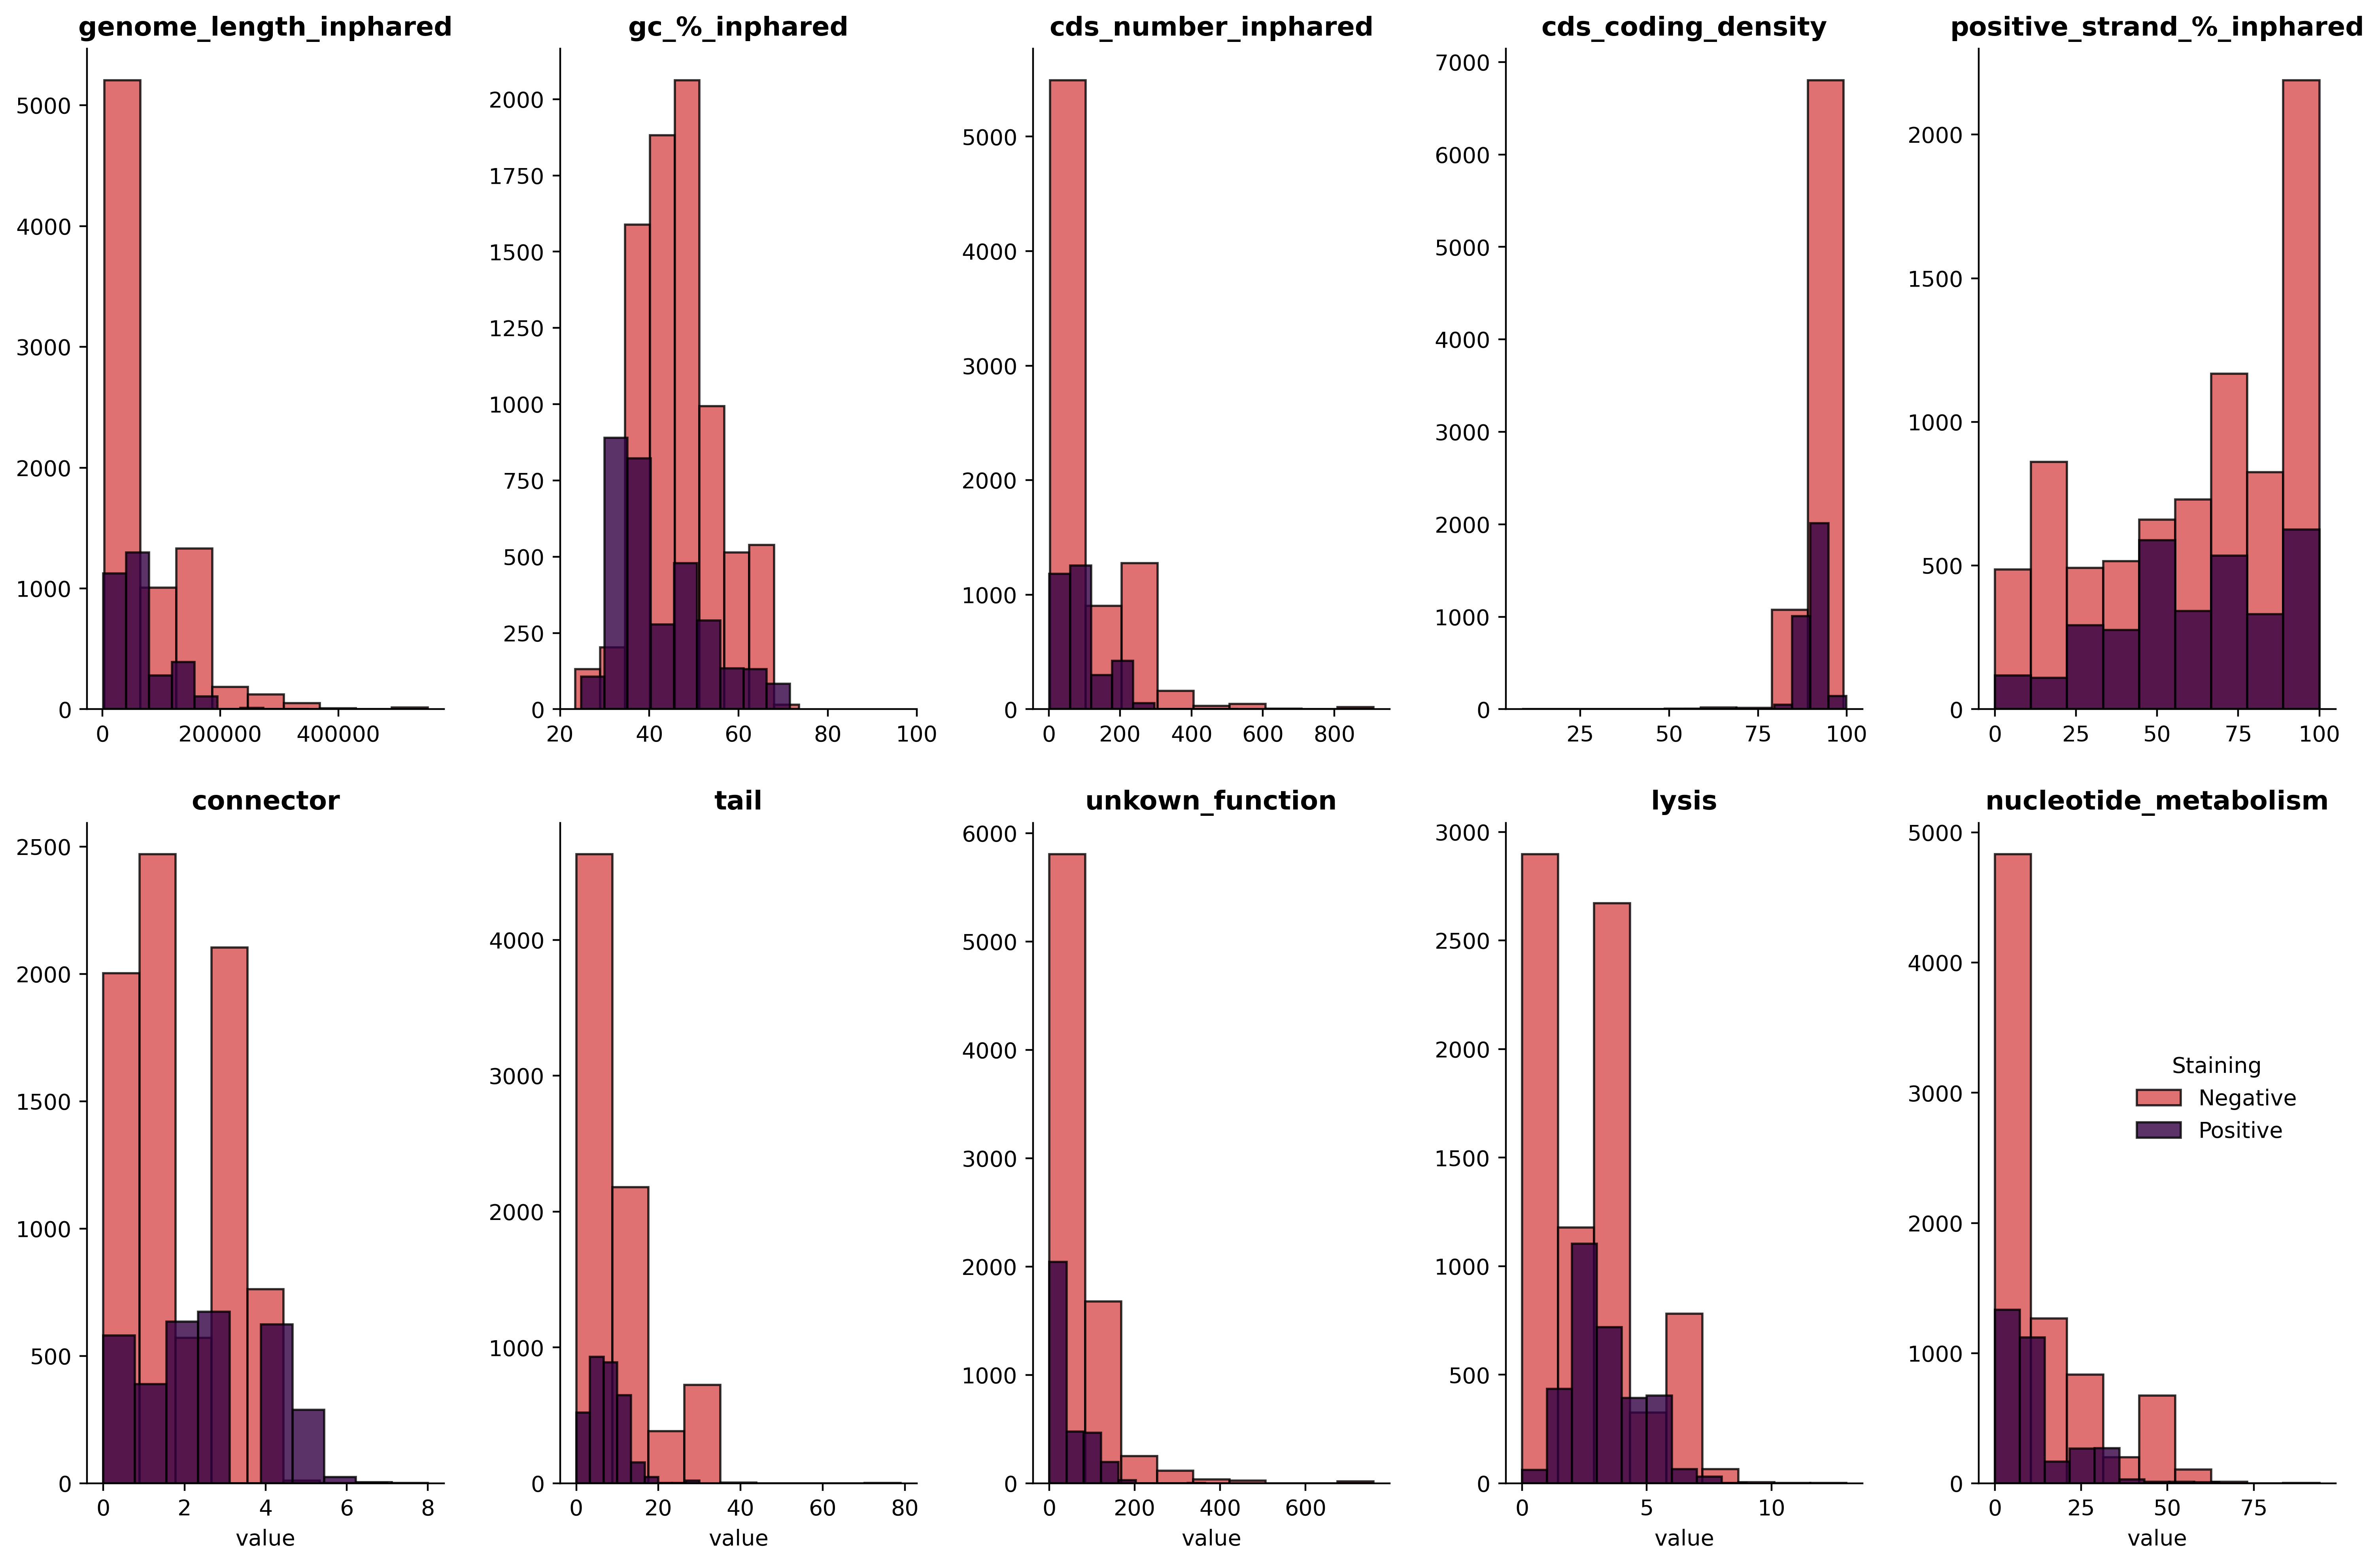

In [33]:
# Define the color palette for the 'staining' groups
palette = {0: '#D74D4F', 1: '#330043'}  # Red for 0, Green for 1
df_melted = pd.melt(df, id_vars='staining', value_vars=['genome_length_inphared', 'gc_%_inphared', 
                                                         'cds_number_inphared', 'cds_coding_density', 
                                                         'positive_strand_%_inphared', 'connector',
                                                         'tail', 'unkown_function', 'lysis', 
                                                         'nucleotide_metabolism'],
                    var_name='variable', value_name='value')


# Define the plotting function with an alpha value and individual bin calculation
def custom_hist(x, color, label, **kwargs):
    bins = np.linspace(min(x), max(x), 10)  # Calculate bins based on the data in 'x'
    plt.hist(x, bins=bins, color=color, label=label, alpha=0.8, **kwargs)

# Set up the FacetGrid with 3 columns per row, no shared x/y axes, and space between subplots
g = sns.FacetGrid(df_melted, col="variable", hue="staining", palette=palette, col_wrap=5, sharex=False, sharey=False)
# Map the histograms to the grid using the custom_hist function
g.map(custom_hist, 'value', ec="k")

# Add a legend with specified placement
g.add_legend(title='Staining', loc='right', bbox_to_anchor=(0.98, 0.3))
# Modify the legend labels
for t, l in zip(g._legend.texts, ["Negative", "Positive"]):
    t.set_text(l)
    
# Set the title for each subplot to the name of the variable and make it bold
for ax, title in zip(g.axes.flatten(), g.col_names):
    ax.set_title(title, fontweight='bold')
    # Modify x-axis ticks for 'gc_%_inphared'
    if title == 'gc_%_inphared':
        ax.set_xticks([20, 40, 60, 80, 100])

# Adjust the layout
# Increase the height parameter to introduce more separation between rows
g.fig.set_size_inches(15, 10)  # Example size, adjust as needed
g.fig.tight_layout( h_pad=2)  # Adjust h_pad for vertical spacing
output_directory = "../reports/figures/"
name = os.path.join(output_directory, '1_barplot_combined.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  


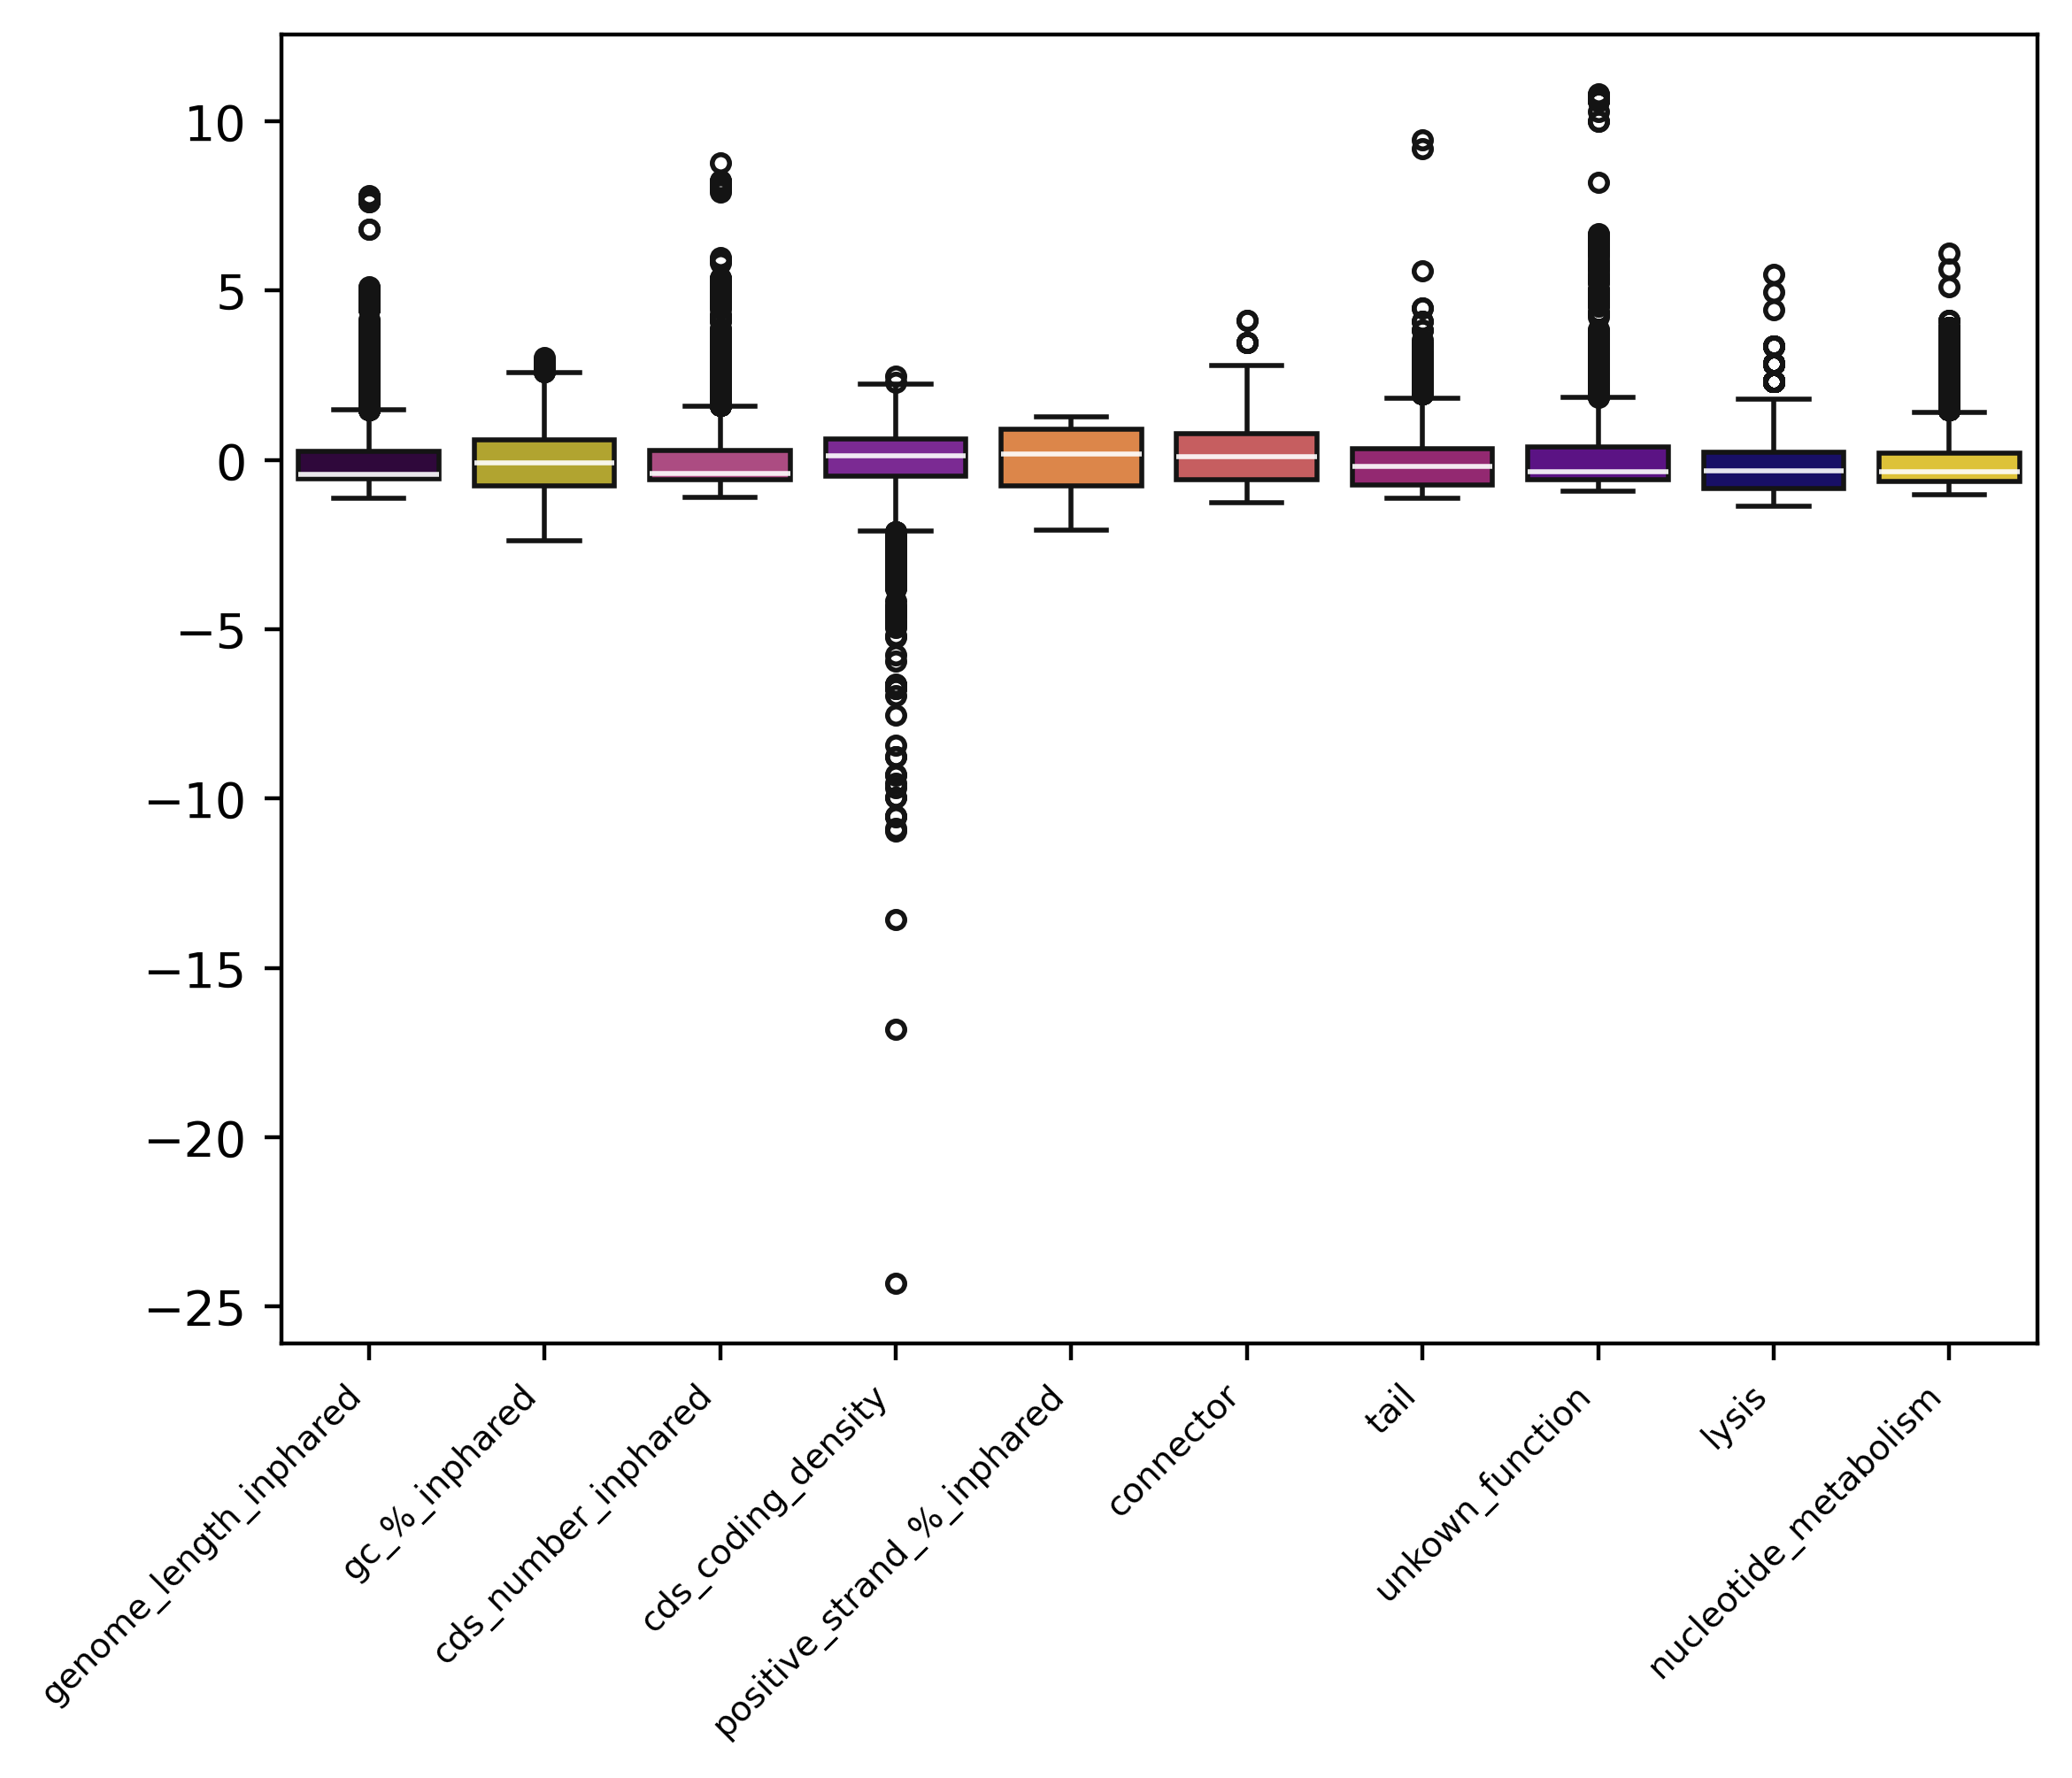

In [34]:
# Boxplot
mean=df.mean(axis=0)
std=df.std(axis=0)

# then we subtract the mean
df_mean=df-mean
# and divide with the standard deviation
df_std=df_mean/std

# then we create the boxplot
plt.figure(dpi=400)


ax = sns.boxplot(data=df_std[['genome_length_inphared','gc_%_inphared', 'cds_number_inphared',
          'cds_coding_density', 'positive_strand_%_inphared', 'connector',
          'tail', 'unkown_function', 'lysis','nucleotide_metabolism']], 
          palette=[C1, C2, C3, C4, C5, C6, C7, C8, C9, C10], 
          showfliers=True, orient="v", medianprops=dict(color="white", alpha=0.9), 
          fliersize = 3.5)

# Reduce the text size of x-axis ticks
plt.xticks(rotation=45, ha='right', fontsize=7.0)  # Adjust fontsize as needed

name = os.path.join(output_directory, '1_boxplot.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  
plt.show()



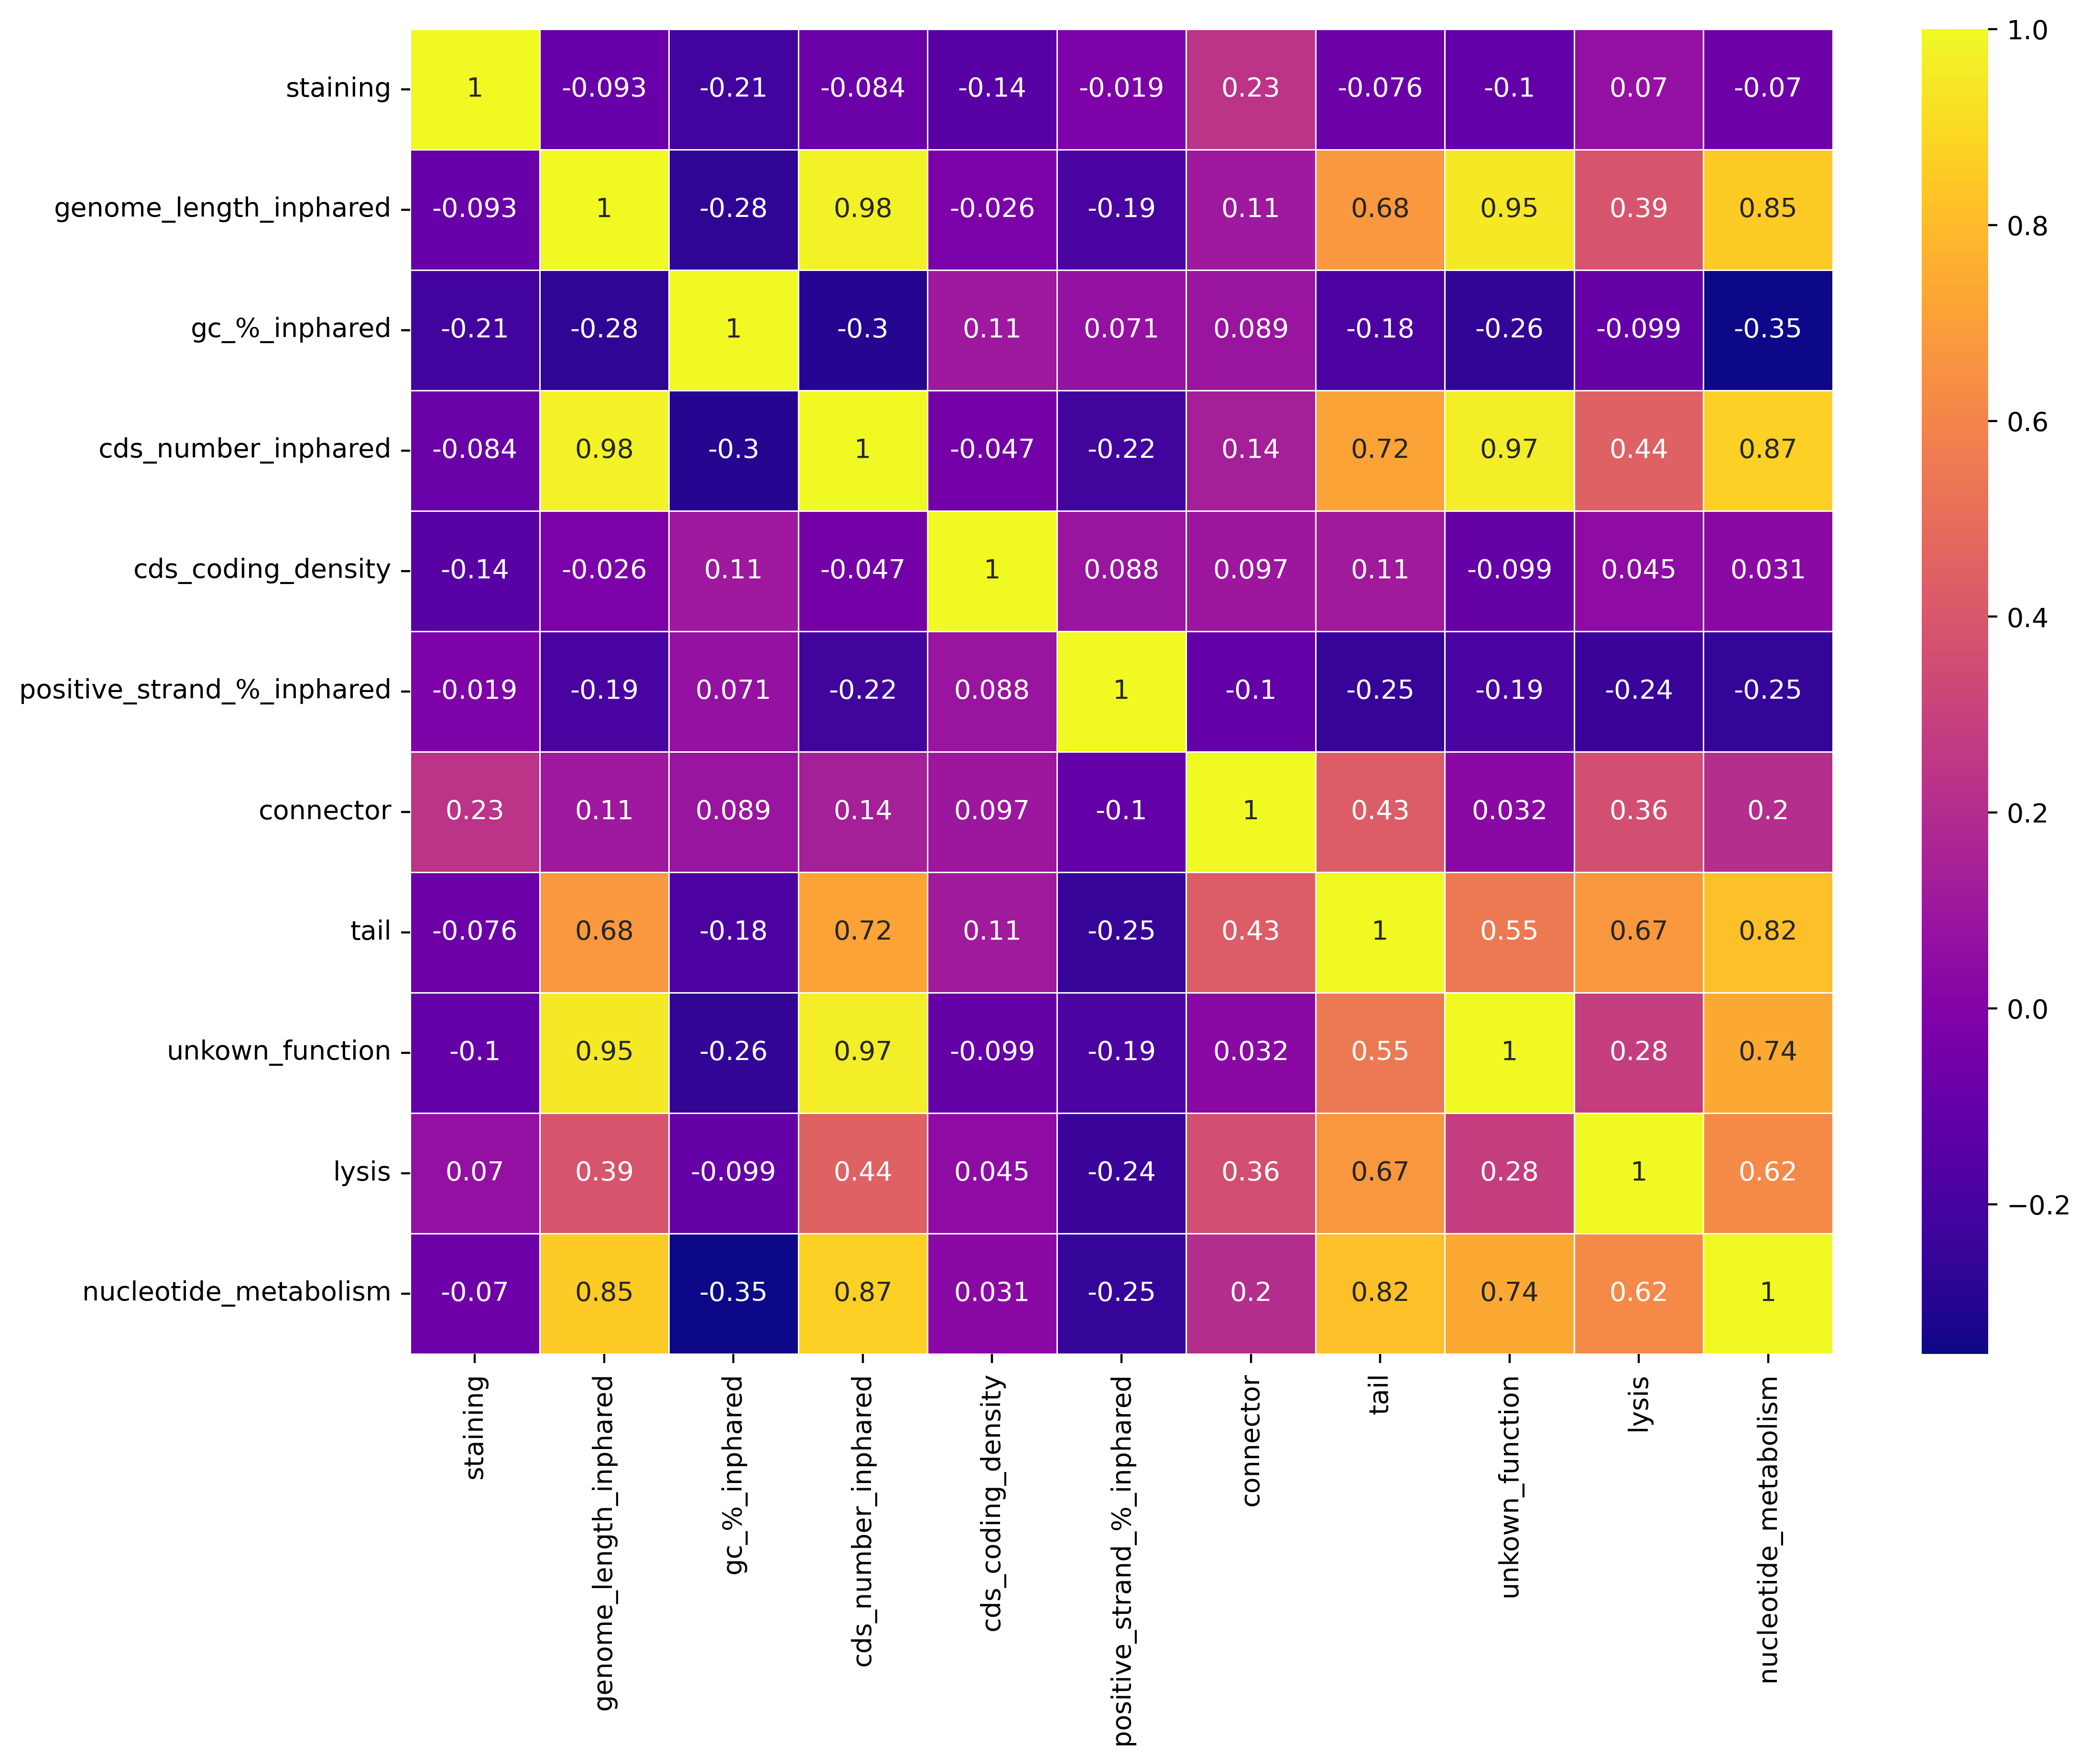

In [35]:
# Heatmap
plt.figure(figsize=(12, 9), dpi=400)


changed_df = df

#creating corr variable to store the changed df
corr = changed_df[['genome_length_inphared','gc_%_inphared', 'cds_number_inphared',
          'cds_coding_density', 'positive_strand_%_inphared', 'connector',
          'tail', 'unkown_function', 'lysis','nucleotide_metabolism', 'staining']].corr()
corr = df.corr()

sns.heatmap(corr, annot=True, cmap='plasma', linewidths=0.5)
name = os.path.join(output_directory, '1_heatmap.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  

## 4.2 Training

- Input: df with engineered features (one is stainig)
- Output: trained model pickle file plus training metrics in plots

In [36]:
# Data for training
print("-> Starting Training of Model ----------------------")

df = pd.read_csv("../data/test/features_with_gram_class.csv")

df = df[['id','staining','genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'tRNAs_inphared', 'cds_coding_density','jumbophage_inphared', 'topology_linear', 
       'topology_circular', 'transl_table',  'CARD_AMR_Genes',
       'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative', 
       'molecule_inphared_type_DNA',  'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA', 'sequence']]

df['staining'] = df['staining'].replace({'negative': 0, 'positive': 1})
df.shape

-> Starting Training of Model ----------------------


(11143, 35)

## 4.3 NetworkX

In [37]:
distances = pd.read_csv('../data/test/test_mash_distances.csv')
from networkx.algorithms import community

# Create a new graph
G = nx.Graph()

# Add edges to the graph based on our distances
for index, row in distances.iterrows():
    distance = 1 - row['Identity'] / 100  # Convert percentage to a float value between 0 and 1
    G.add_edge(row['Genome1'], row['Genome2'], weight=distance)

# Verify that the graph is not empty
if G.number_of_edges() == 0:
    raise ValueError("The graph G has no edges. Check the 'mash_distances.csv' file for correct data.")

# If there are edges, print the number of edges and nodes
print(f"The graph G has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Proceed to detect communities only if the graph is not empty
if G.number_of_nodes() > 0:
    communities = community.greedy_modularity_communities(G, weight='weight')
else:
    print("Cannot find communities in an empty graph.")

# Create a mapping dictionary from accession code to community index
accession_to_community = {}
for i, community in enumerate(communities):
    for accession in community:
        accession_to_community[accession] = i

# Map the 'Accession' column to a new 'Community' column
df['Community'] = df['id'].map(accession_to_community)

df= df.set_index('id')

The graph G has 11143 nodes and 50133 edges.


## 4.4 Setting up the splits

In [38]:
X = df.drop(['staining', 'Community', 'sequence'], axis=1)
y = df['staining']

groups = df['Community'].to_list()
groups = np.array(groups)
folds = 10
group_kfold = GroupKFold(n_splits=folds)
print(group_kfold)

GroupKFold(n_splits=10)


In [39]:
features = ['genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'tRNAs_inphared', 'cds_coding_density','jumbophage_inphared', 'topology_linear', 
       'topology_circular', 'transl_table',  'CARD_AMR_Genes',
       'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative', 
       'molecule_inphared_type_DNA',  'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA' ]

# features = ['genome_length_inphared','gc_%_inphared', 'cds_number_inphared',
#           'cds_coding_density', 'positive_strand_%_inphared', 'connector',
#           'tail', 'unkown_function', 'lysis','nucleotide_metabolism',
# ]

target = 'staining'

## 4.5 Models

### 4.5.1 Random

In [40]:
group_kfold = GroupKFold(n_splits=10)
# Variables to track the best model and its performance
best_mcc = -1  # Initialize with a low MCC
best_model = None

# Lists to store metrics
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_random = []  # True Positive Rates
fprs_random = []  # False Positive Rates
precisions_random = []
recalls_random = []
roc_auc_values = []
pr_auc_values = []
tp_values = []
fp_values = []
tn_values = []
fn_values = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_validation_scaled = scaler.transform(X_validation_fold)
    
    # Train the random classifier
    random_model = DummyClassifier(strategy='uniform')
    random_model.fit(X_train_scaled, y_train_fold)

    # Predict class labels and probabilities
    y_pred = random_model.predict(X_validation_scaled)
    y_pred_proba = random_model.predict_proba(X_validation_scaled)[:, 1]
    print("Printing y_pred_proba" , str(y_pred_proba))
    # Encode labels
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)
    logloss = log_loss(y_validation_encoded, y_pred_proba)
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)
    f1score = f1_score(y_validation_encoded, y_pred_encoded)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)


    if mcc > best_mcc:
        best_mcc = mcc
        best_model = random_model

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_random.append(tpr)
    fprs_random.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    print("Precision",str(precision))
    print("Recall", str(recall))
    precisions_random.append(precision)

    recalls_random.append(recall)

    pr_auc = auc(recall, precision)
    print(f'Calculated PR AUC: {pr_auc:.2f}')
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_validation_encoded, y_pred_encoded).ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_random = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values
})

# output = "../models/"
# # After the loop, save the best model
# if best_model is not None:
#     model_filename = os.path.join(output, 'random.pkl')

#     with open(model_filename, 'wb') as file:
#         pickle.dump(best_model, file)
#     print(f"Best model saved with MCC: {best_mcc}")
# else:
#     print("No model was saved.")

metrics_random

Training fold 1...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.26607143 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.63
Training fold 2...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.26517857 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.63
Training fold 3...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.27946429 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 4...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.28125 1.     ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 5...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.28930818 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 6...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.27837838 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.64
Training fold 7...
Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.3009009 1.       ]
Recall [1. 0.]
Calculated PR AUC: 0.65


Printing y_pred_proba [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Precision [0.31351351 1.        ]
Recall [1. 0.]
Calculated PR AUC: 0.66
Best model saved with MCC: 0.04313821826964989


Fold  Accuracy  Balanced Accuracy  Log Loss       MSE  F1 Score       MCC  \
0     1  0.480357           0.486618  0.693147  0.519643  0.338636 -0.023672   
1     2  0.478571           0.465514  0.693147  0.521429  0.308057 -0.060909   
2     3  0.485714           0.484708  0.693147  0.514286  0.343964 -0.027449   
3     4  0.504464           0.500690  0.693147  0.495536  0.358382  0.001241   
4     5  0.492363           0.495548  0.693147  0.507637  0.364454 -0.008077   
5     6  0.487387           0.485794  0.693147  0.512613  0.343714 -0.025468   
6     7  0.521622           0.512053  0.693147  0.478378  0.380397  0.022150   
7     8  0.529730           0.523215  0.693147  0.470270  0.402746  0.043138   
8     9  0.510811           0.511165  0.693147  0.489189  0.385051  0.020450   
9    10  0.484685           0.487284  0.693147  0.515315  0.375546 -0.023604   

   ROC AUC    PR AUC  True Positives  False Positives  True Negatives  \
0      0.5  0.633036             149              433             389   
1      0.5  0.632589             130              417             406   
2      0.5  0.639732             151              414             393   
3      0.5  0.640625             155              395             410   
4      0.5  0.644654             162              405             386   
5      0.5  0.639189             149              409             392   
6      0.5  0.650450             163              360             416   
7      0.5  0.656757             176              350             412   
8      0.5  0.649550             170              381             397   
9      0.5  0.656757             172              396             366   

   False Negatives  
0              149  
1              167  
2              162  
3              160  
4              160  
5              160  
6              171  
7              172  
8              162  
9              176

### 4.5.2 Logistic Regressor

In [44]:
feature_importances = np.zeros(len(features))
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_lr = []  # True Positive Rates
fprs_lr = []  # False Positive Rates
precisions_lr = []
recalls_lr = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives
best_mcc = -1  # Initialize with a low MCC
best_model = None


for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups[train_index]
    
    # Standardize the features (fit on training data, transform on both training and test data)
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_validation_fold = scaler.transform(X_validation_fold)  # Use the same scaler to transform the test data
    
    params = {'C': 0.1, 'class_weight': None, 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'saga'}
    # Train a RandomForestClassifier model
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_fold, y_train_fold)


    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = model.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = '1'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    if mcc > best_mcc:
        best_mcc = mcc
        best_model = model

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_lr.append(tpr)
    fprs_lr.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions_lr.append(precision)
    recalls_lr.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_lr = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values})


# output = "../models/"
# # After the loop, save the best model
# if best_model is not None:
#     model_filename = os.path.join(output, 'logistic.pkl')

#     with open(model_filename, 'wb') as file:
#         pickle.dump(best_model, file)
#     print(f"Best model saved with MCC: {best_mcc}")
# else:
#     print("No model was saved.")


metrics_lr


Training fold 1...
Training fold 2...
Training fold 3...


Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...
Training fold 10...
Best model saved with MCC: 0.5556708582917698


Fold  Accuracy  Balanced Accuracy  Log Loss       MSE  F1 Score       MCC  \
0     1  0.778571           0.670529  0.469957  0.221429  0.513725  0.384734   
1     2  0.813393           0.718086  0.405944  0.186607  0.594175  0.486300   
2     3  0.770536           0.667686  0.481507  0.229464  0.514178  0.381439   
3     4  0.790179           0.685921  0.455139  0.209821  0.545455  0.434826   
4     5  0.776280           0.666754  0.489670  0.223720  0.512720  0.402768   
5     6  0.801802           0.704641  0.447421  0.198198  0.576923  0.467517   
6     7  0.809910           0.731882  0.435231  0.190090  0.629174  0.520670   
7     8  0.818018           0.737092  0.441738  0.181982  0.641844  0.555671   
8     9  0.771171           0.674451  0.498248  0.228829  0.531365  0.407879   
9    10  0.777477           0.706003  0.490378  0.222523  0.591736  0.453137   

    ROC AUC    PR AUC  True Positives  False Positives  True Negatives  \
0  0.787472  0.618621             131               81             741   
1  0.854977  0.718409             153               65             758   
2  0.792669  0.630058             136               80             727   
3  0.812860  0.664353             141               61             744   
4  0.783889  0.623763             131               58             733   
5  0.828463  0.670580             150               61             740   
6  0.845731  0.739172             179               56             720   
7  0.854670  0.749784             181               35             727   
8  0.798731  0.623571             144               66             712   
9  0.815952  0.662885             179               78             684   

   False Negatives  
0              167  
1              144  
2              177  
3              174  
4              191  
5              159  
6              155  
7              167  
8              188  
9              169

### 4.5.3 Random Forest

In [45]:
feature_importances = np.zeros(len(features))
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_rf = []  # True Positive Rates
fprs_rf = []  # False Positive Rates
precisions_rf = []
recalls_rf = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives
best_mcc = -1  # Initialize with a low MCC
best_model = None
best_scaler = StandardScaler()


for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups[train_index]
    
    # Standardize the features (fit on training data, transform on both training and test data)
    scaler  = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_validation_fold = scaler.transform(X_validation_fold)  # Use the same scaler to transform the test data
    
    params =  {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
    # Train a RandomForestClassifier model
    model = RandomForestClassifier(**params)
    model.feature_names_in_ = features

    model.fit(X_train_fold, y_train_fold)

    # Sum the feature importances from this fold
    feature_importances += model.feature_importances_

    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = model.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = '1'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    if mcc > best_mcc:
        best_mcc = mcc
        best_model = model
        best_scaler = scaler

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_rf.append(tpr)
    fprs_rf.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions_rf.append(precision)
    recalls_rf.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_rf = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values})


# output = "../models/"
# # After the loop, save the best model
# if best_model is not None:
#     model_filename = os.path.join(output, 'random_forest.pkl')

#     with open(model_filename, 'wb') as file:
#         pickle.dump(best_model, file)
#     print(f"Best model saved with MCC: {best_mcc}")
# else:
#     print("No model was saved.")


# # Save the best scaler using pickle
# scaler_filename = os.path.join(output, 'scaler.pkl')
# with open(scaler_filename, 'wb') as scaler_file:
#     pickle.dump(best_scaler, scaler_file)

metrics_rf


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...
Training fold 10...
Best model saved with MCC: 0.9528139929465668


Fold  Accuracy  Balanced Accuracy  Log Loss       MSE  F1 Score       MCC  \
0     1  0.971429           0.952726  0.080299  0.028571  0.944444  0.926256   
1     2  0.979464           0.968811  0.093156  0.020536  0.960684  0.946996   
2     3  0.966964           0.948717  0.095943  0.033036  0.938843  0.917287   
3     4  0.968750           0.950242  0.117756  0.031250  0.942339  0.922194   
4     5  0.975741           0.962678  0.148147  0.024259  0.956938  0.940739   
5     6  0.972072           0.956796  0.073448  0.027928  0.948419  0.929992   
6     7  0.980180           0.969624  0.061392  0.019820  0.966258  0.952814   
7     8  0.972973           0.967045  0.112600  0.027027  0.956647  0.937048   
8     9  0.969369           0.954839  0.085954  0.030631  0.947205  0.926547   
9    10  0.974775           0.969918  0.085756  0.025225  0.959654  0.941314   

    ROC AUC    PR AUC  True Positives  False Positives  True Negatives  \
0  0.996295  0.991505             272                6             816   
1  0.997175  0.992061             281                7             816   
2  0.992634  0.984301             284                8             799   
3  0.991379  0.985311             286                6             799   
4  0.988832  0.984063             300                5             786   
5  0.997184  0.993335             285                7             794   
6  0.998277  0.996409             315                3             773   
7  0.993619  0.989748             331               13             749   
8  0.996028  0.991558             305                7             771   
9  0.994351  0.990246             333               13             749   

   False Negatives  
0               26  
1               16  
2               29  
3               29  
4               22  
5               24  
6               19  
7               17  
8               27  
9               15

### 4.5.4 LightGBM

In [47]:
import lightgbm as lgb

In [54]:
feature_importances = np.zeros(len(features))
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs_rf = []  # True Positive Rates
fprs_rf = []  # False Positive Rates
precisions_rf = []
recalls_rf = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives
best_mcc = -1  # Initialize with a low MCC
best_model = None
best_scaler = StandardScaler()


for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Training fold {i + 1}...")
    X_train_fold, X_validation_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_validation_fold = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups[train_index]
    
    # Standardize the features (fit on training data, transform on both training and test data)
    scaler  = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_validation_fold = scaler.transform(X_validation_fold)  # Use the same scaler to transform the test data
    
    # Train a LGBM model model
 
    model = lgb.LGBMClassifier()
    model.fit(X_train_fold, y_train_fold, feature_name=features)


    # Sum the feature importances from this fold
    feature_importances += model.feature_importances_

    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = model.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = '1'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    if mcc > best_mcc:
        best_mcc = mcc
        best_model = model
        best_scaler = scaler

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs_rf.append(tpr)
    fprs_rf.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions_rf.append(precision)
    recalls_rf.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_lgbm = pd.DataFrame({
    'Fold': range(1, folds+1),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values})


# output = "../models/"
# # After the loop, save the best model
# if best_model is not None:
#     model_filename = os.path.join(output, 'random_forest.pkl')

#     with open(model_filename, 'wb') as file:
#         pickle.dump(best_model, file)
#     print(f"Best model saved with MCC: {best_mcc}")
# else:
#     print("No model was saved.")


# # Save the best scaler using pickle
# scaler_filename = os.path.join(output, 'scaler.pkl')
# with open(scaler_filename, 'wb') as scaler_file:
#     pickle.dump(best_scaler, scaler_file)

metrics_lgbm


Training fold 1...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2918, number of negative: 7105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2862
[LightGBM] [Info] Number of data points in the train set: 10023, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291130 -> initscore=-0.889900
[LightGBM] [Info] Start training from score -0.889900
Training fold 2...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2919, number of negative: 7104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in th

Fold  Accuracy  Balanced Accuracy  Log Loss       MSE  F1 Score       MCC  \
0     1  0.958036           0.933976  0.119012  0.041964  0.917976  0.891138   
1     2  0.971429           0.957964  0.091827  0.028571  0.945205  0.926138   
2     3  0.947321           0.922375  0.148802  0.052679  0.901830  0.867319   
3     4  0.967857           0.952519  0.117690  0.032143  0.941368  0.919841   
4     5  0.957772           0.938988  0.142191  0.042228  0.924559  0.896266   
5     6  0.973874           0.961026  0.114297  0.026126  0.952066  0.934528   
6     7  0.964865           0.946733  0.101199  0.035135  0.939158  0.916126   
7     8  0.957658           0.944961  0.125526  0.042342  0.930984  0.900921   
8     9  0.954955           0.936786  0.126544  0.045045  0.922118  0.891521   
9    10  0.954054           0.941556  0.129124  0.045946  0.925329  0.892502   

    ROC AUC    PR AUC  True Positives  False Positives  True Negatives  \
0  0.990210  0.977019             263               12             810   
1  0.992239  0.983613             276               11             812   
2  0.979865  0.963327             271               17             790   
3  0.988883  0.979154             289               10             795   
4  0.980248  0.968407             288               13             778   
5  0.984906  0.978780             288                8             793   
6  0.992793  0.988046             301                6             770   
7  0.985444  0.979731             317               16             746   
8  0.990457  0.980486             296               14             764   
9  0.986394  0.977159             316               19             743   

   False Negatives  
0               35  
1               21  
2               42  
3               26  
4               34  
5               21  
6               33  
7               31  
8               36  
9               32

## 4.6 Feature importance

In [59]:
X_train, X_validation, y_train, y_validation = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

Logistic regressor

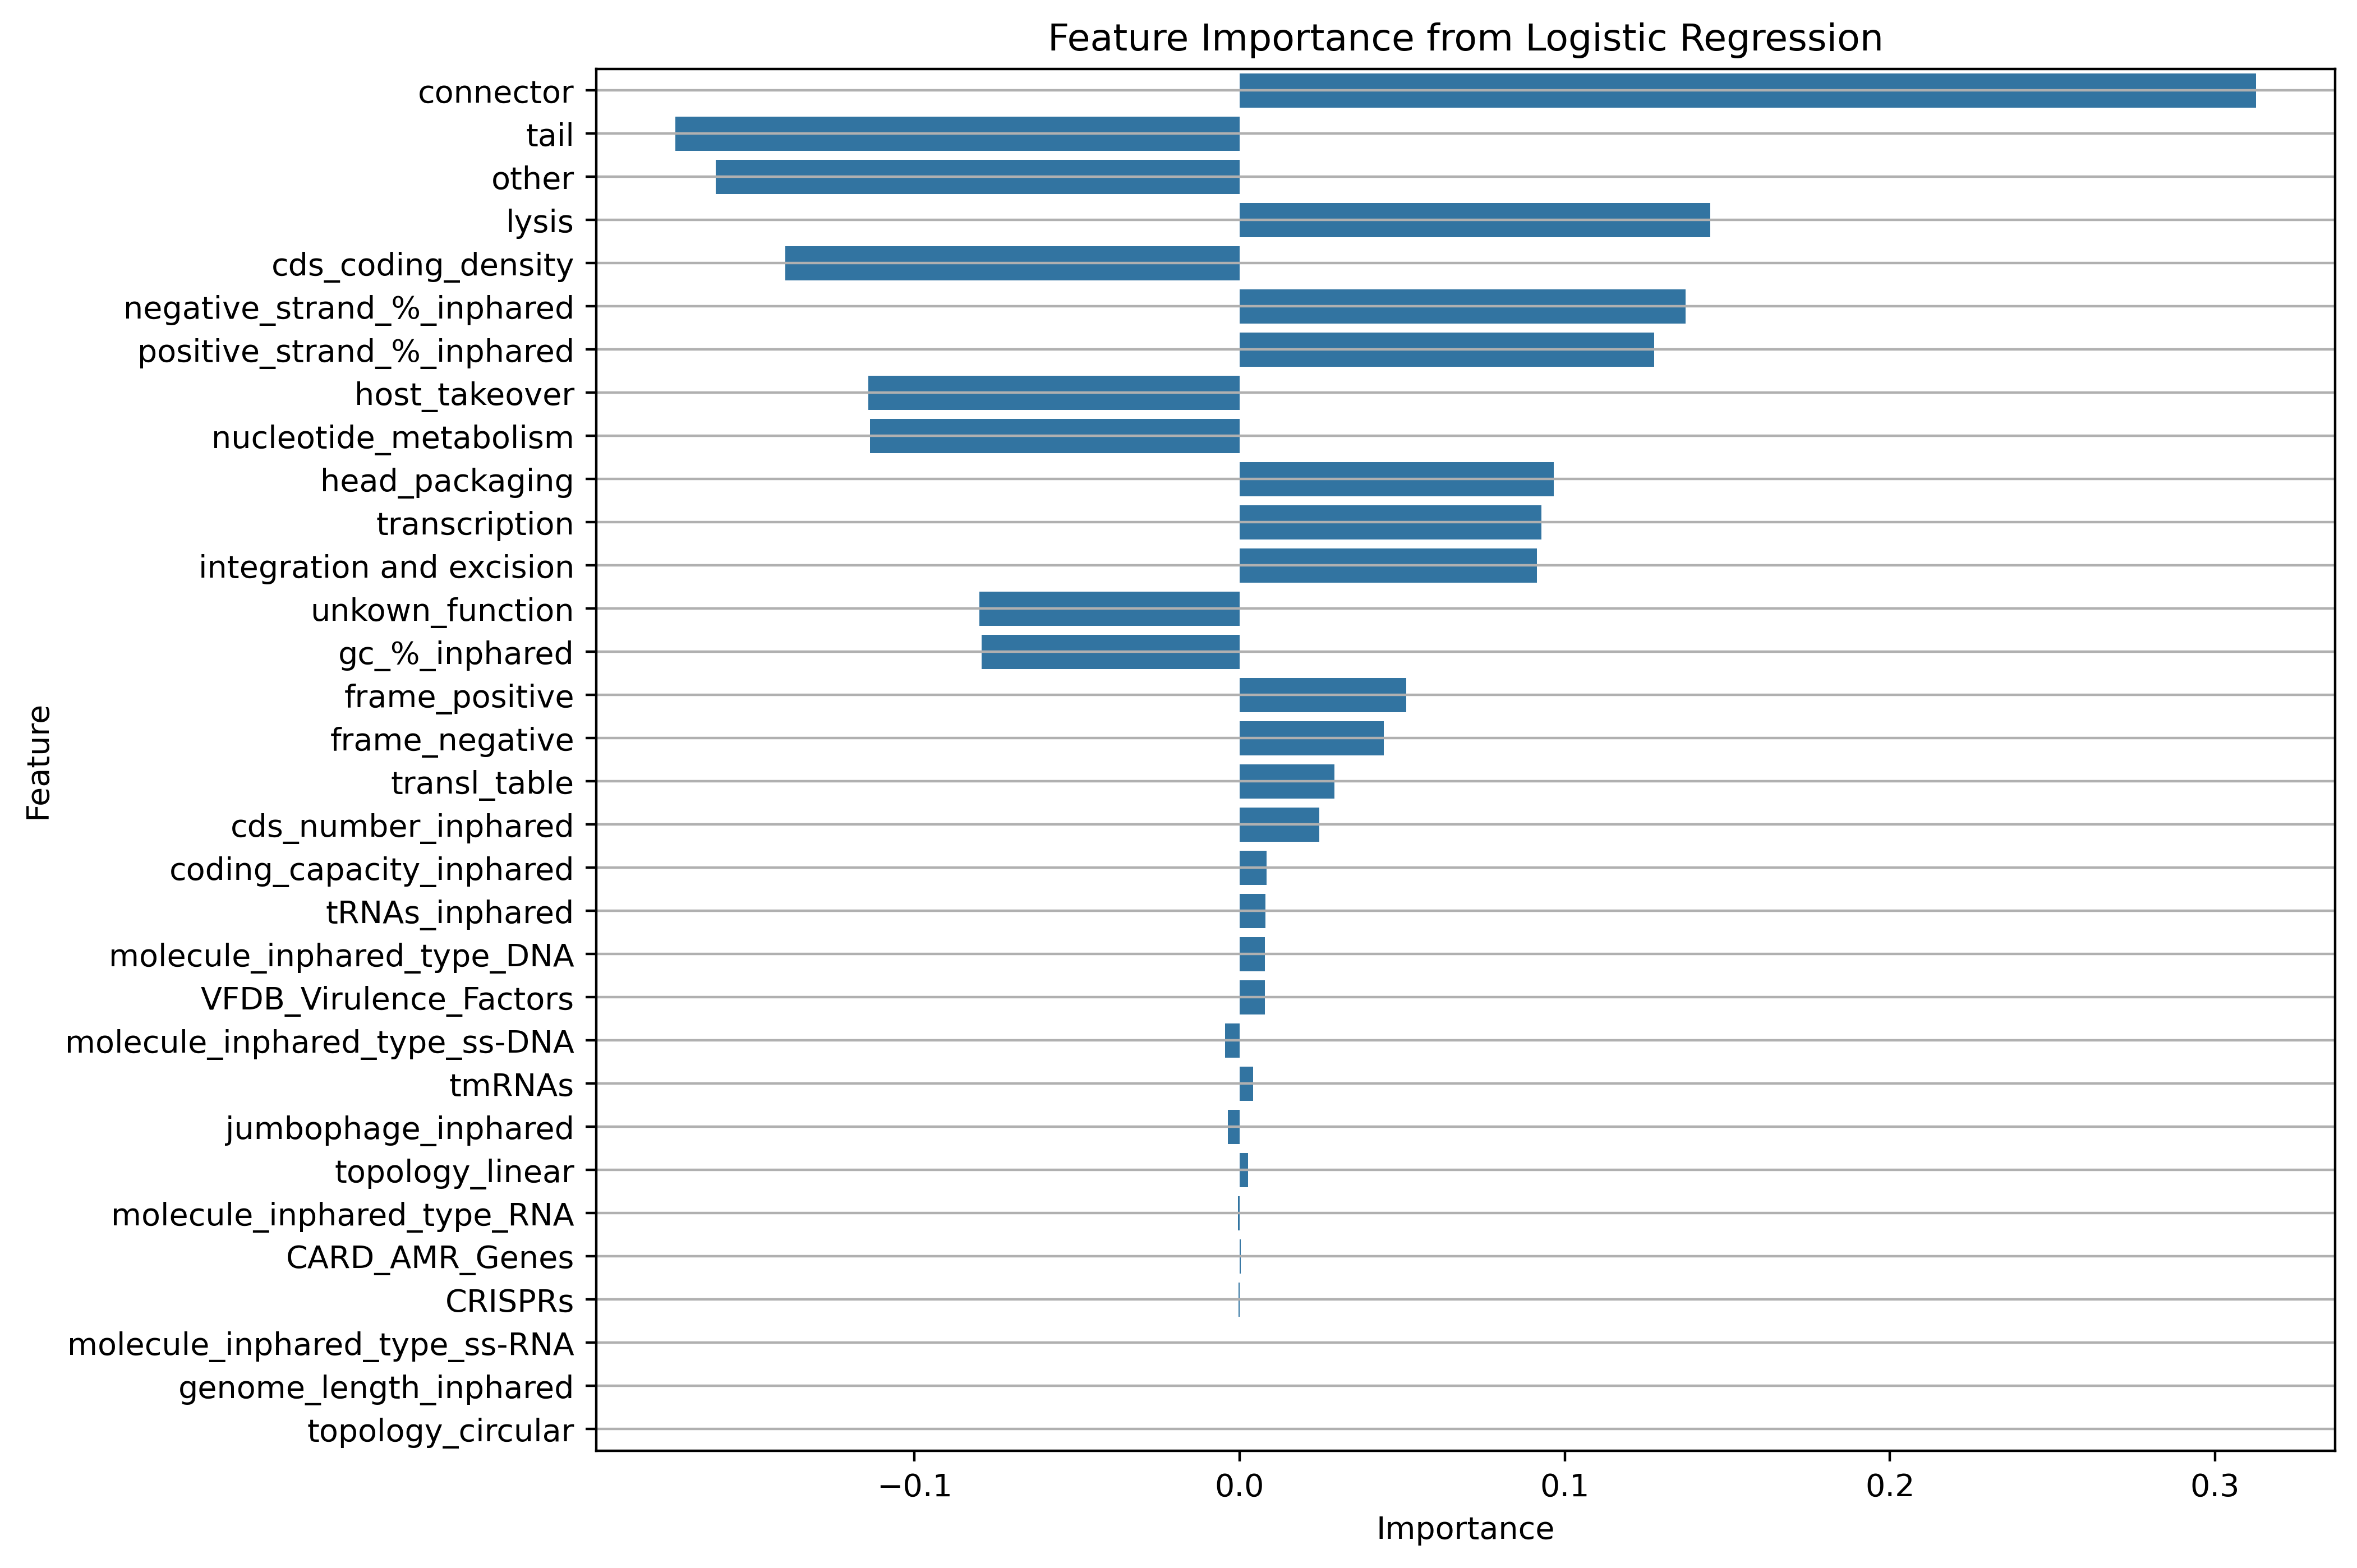

In [61]:
from sklearn.linear_model import LogisticRegression

# Assuming X_train and y_train are your features and target variable
logistic_model = LogisticRegression(max_iter = 10000)
logistic_model.fit(X_train, y_train)

# Get the coefficients
logistic_importance = logistic_model.coef_[0]  # Coefficients for the features

# Match the feature names with the coefficients
feature_names = X.columns
logistic_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': logistic_importance})

# Sort by absolute value of importance
logistic_feature_importance = logistic_feature_importance.reindex(logistic_feature_importance.Importance.abs().sort_values(ascending=False).index)
# Plotting feature importances for Logistic Regression
plt.figure(figsize=(10, 8))
sns.barplot(data=logistic_feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance from Logistic Regression')
# Add horizontal grid lines
plt.grid(axis='y')


Random Forest

Text(0.5, 1.0, 'Feature Importance from Random Forest')

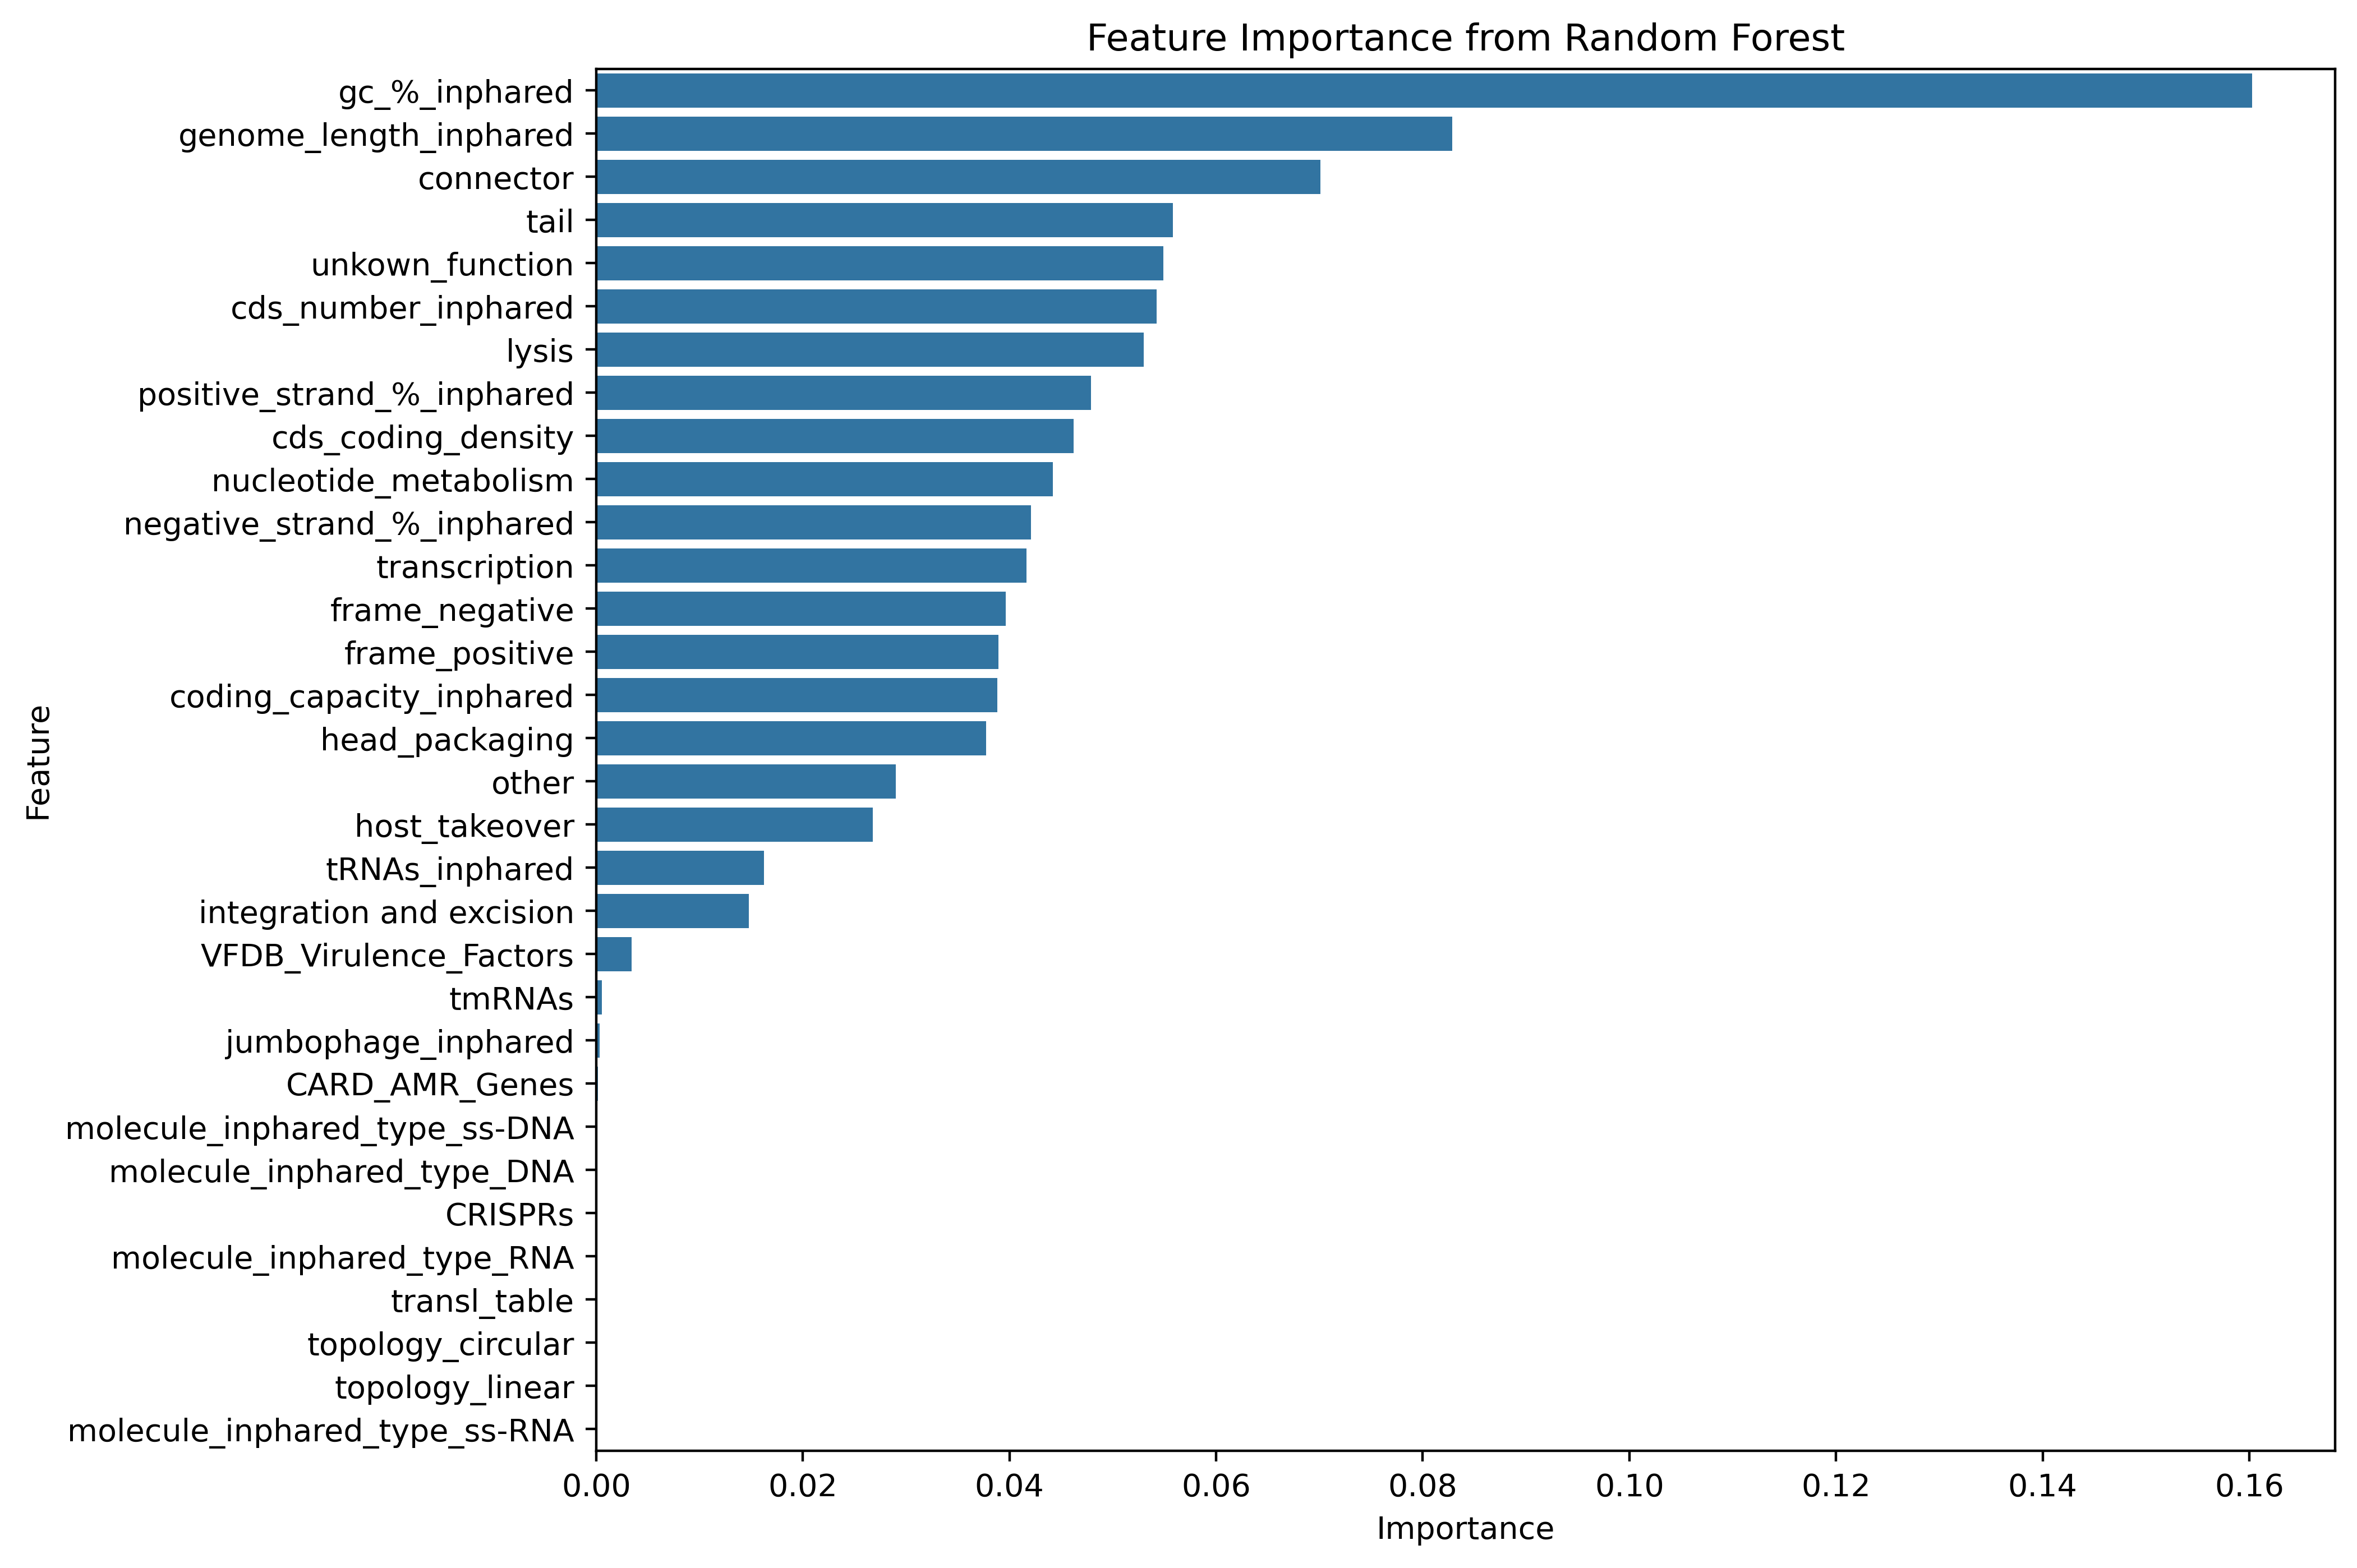

In [60]:
# Assuming X_train and y_train are your features and target variable
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

# Get feature importances
forest_importances = random_forest_model.feature_importances_

# Match the feature names with the importances
feature_names = X.columns
forest_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': forest_importances})

# Sort by the importance scores
forest_feature_importance = forest_feature_importance.reindex(forest_feature_importance.Importance.sort_values(ascending=False).index)


# Plotting feature importances for Random Forest
plt.figure(figsize=(10, 8))
sns.barplot(data=forest_feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance from Random Forest')


LightGBM

In [55]:
# Get feature importances
importance_split = model.booster_.feature_importance(importance_type='split')
importance_gain = model.booster_.feature_importance(importance_type='gain')

# Convert to DataFrame for easy visualization
feature_names = model.feature_name_
df_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Split)': importance_split,
    'Importance (Gain)': importance_gain
}).sort_values(by='Importance (Gain)', ascending=False)

print(df_feature_importances)

                          Feature  Importance (Split)  Importance (Gain)
1                   gc_%_inphared                 428       13585.375963
0          genome_length_inphared                 289        6426.744018
15                      connector                 134        5633.053839
22                           tail                 195        5510.478501
20          nucleotide_metabolism                 175        3504.079094
19                          lysis                 129        2772.790267
25                unkown_function                 182        2571.055939
16                 head_packaging                 173        2261.471931
7              cds_coding_density                 151        2013.459313
17                  host_takeover                 103        1616.523332
3      positive_strand_%_inphared                 109        1589.586180
2             cds_number_inphared                 137        1356.389741
21                          other                  

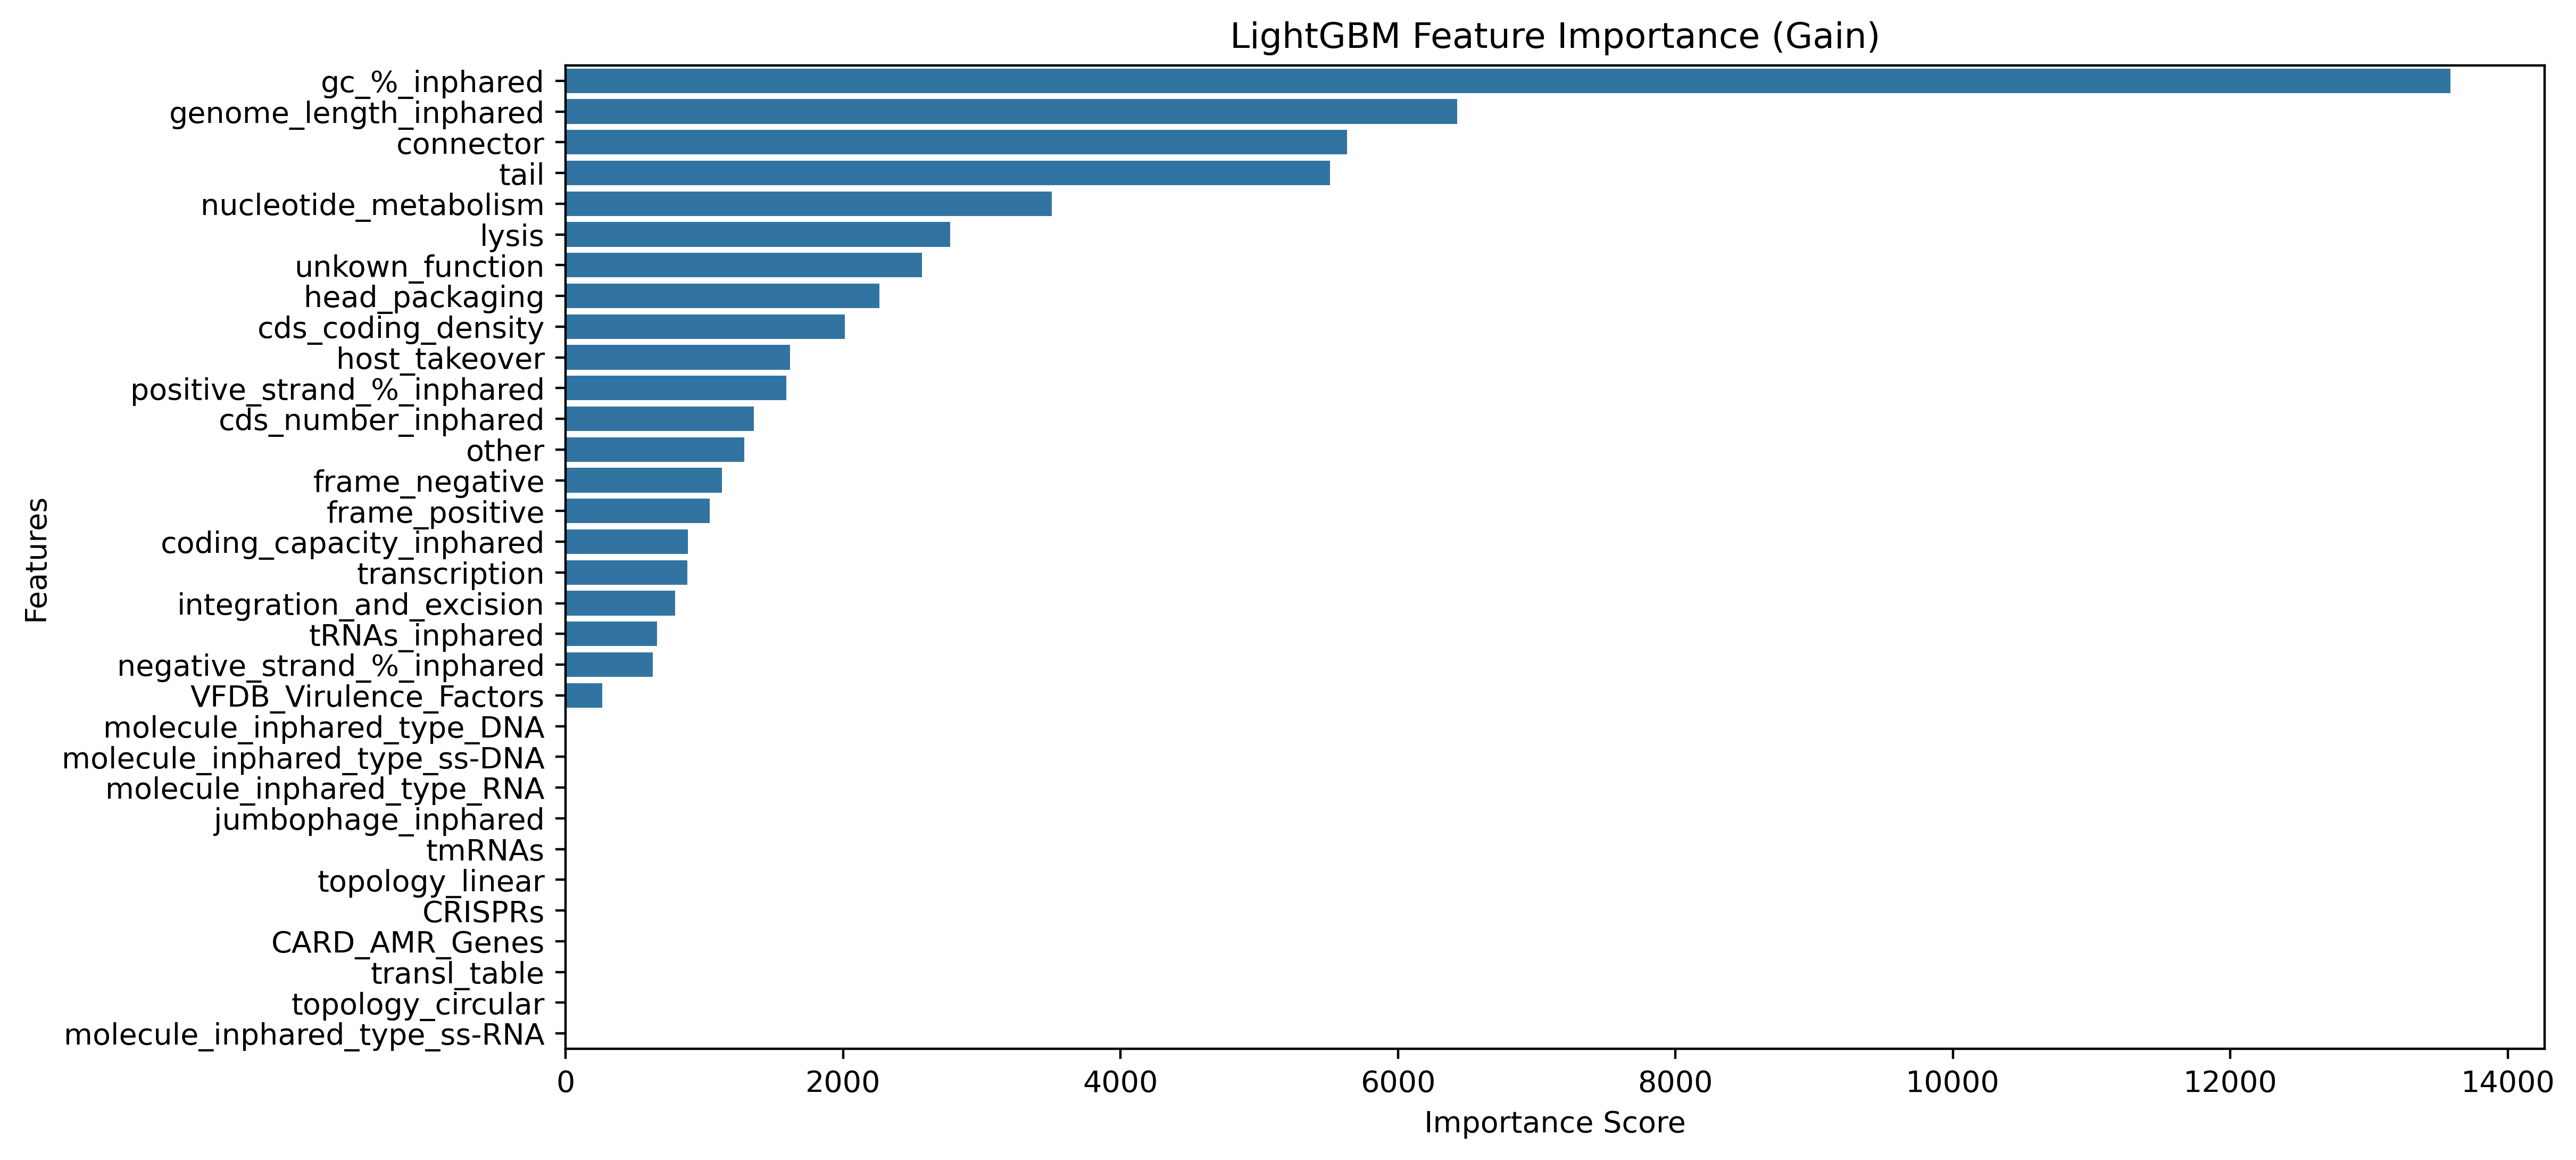

In [56]:
# Plotting
plt.figure(figsize=(12, 6))

sns.barplot(x='Importance (Gain)', y='Feature', data=df_feature_importances)

plt.title('LightGBM Feature Importance (Gain)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 4.7 Learning curves

### 4.7.1 Logistic Regressor

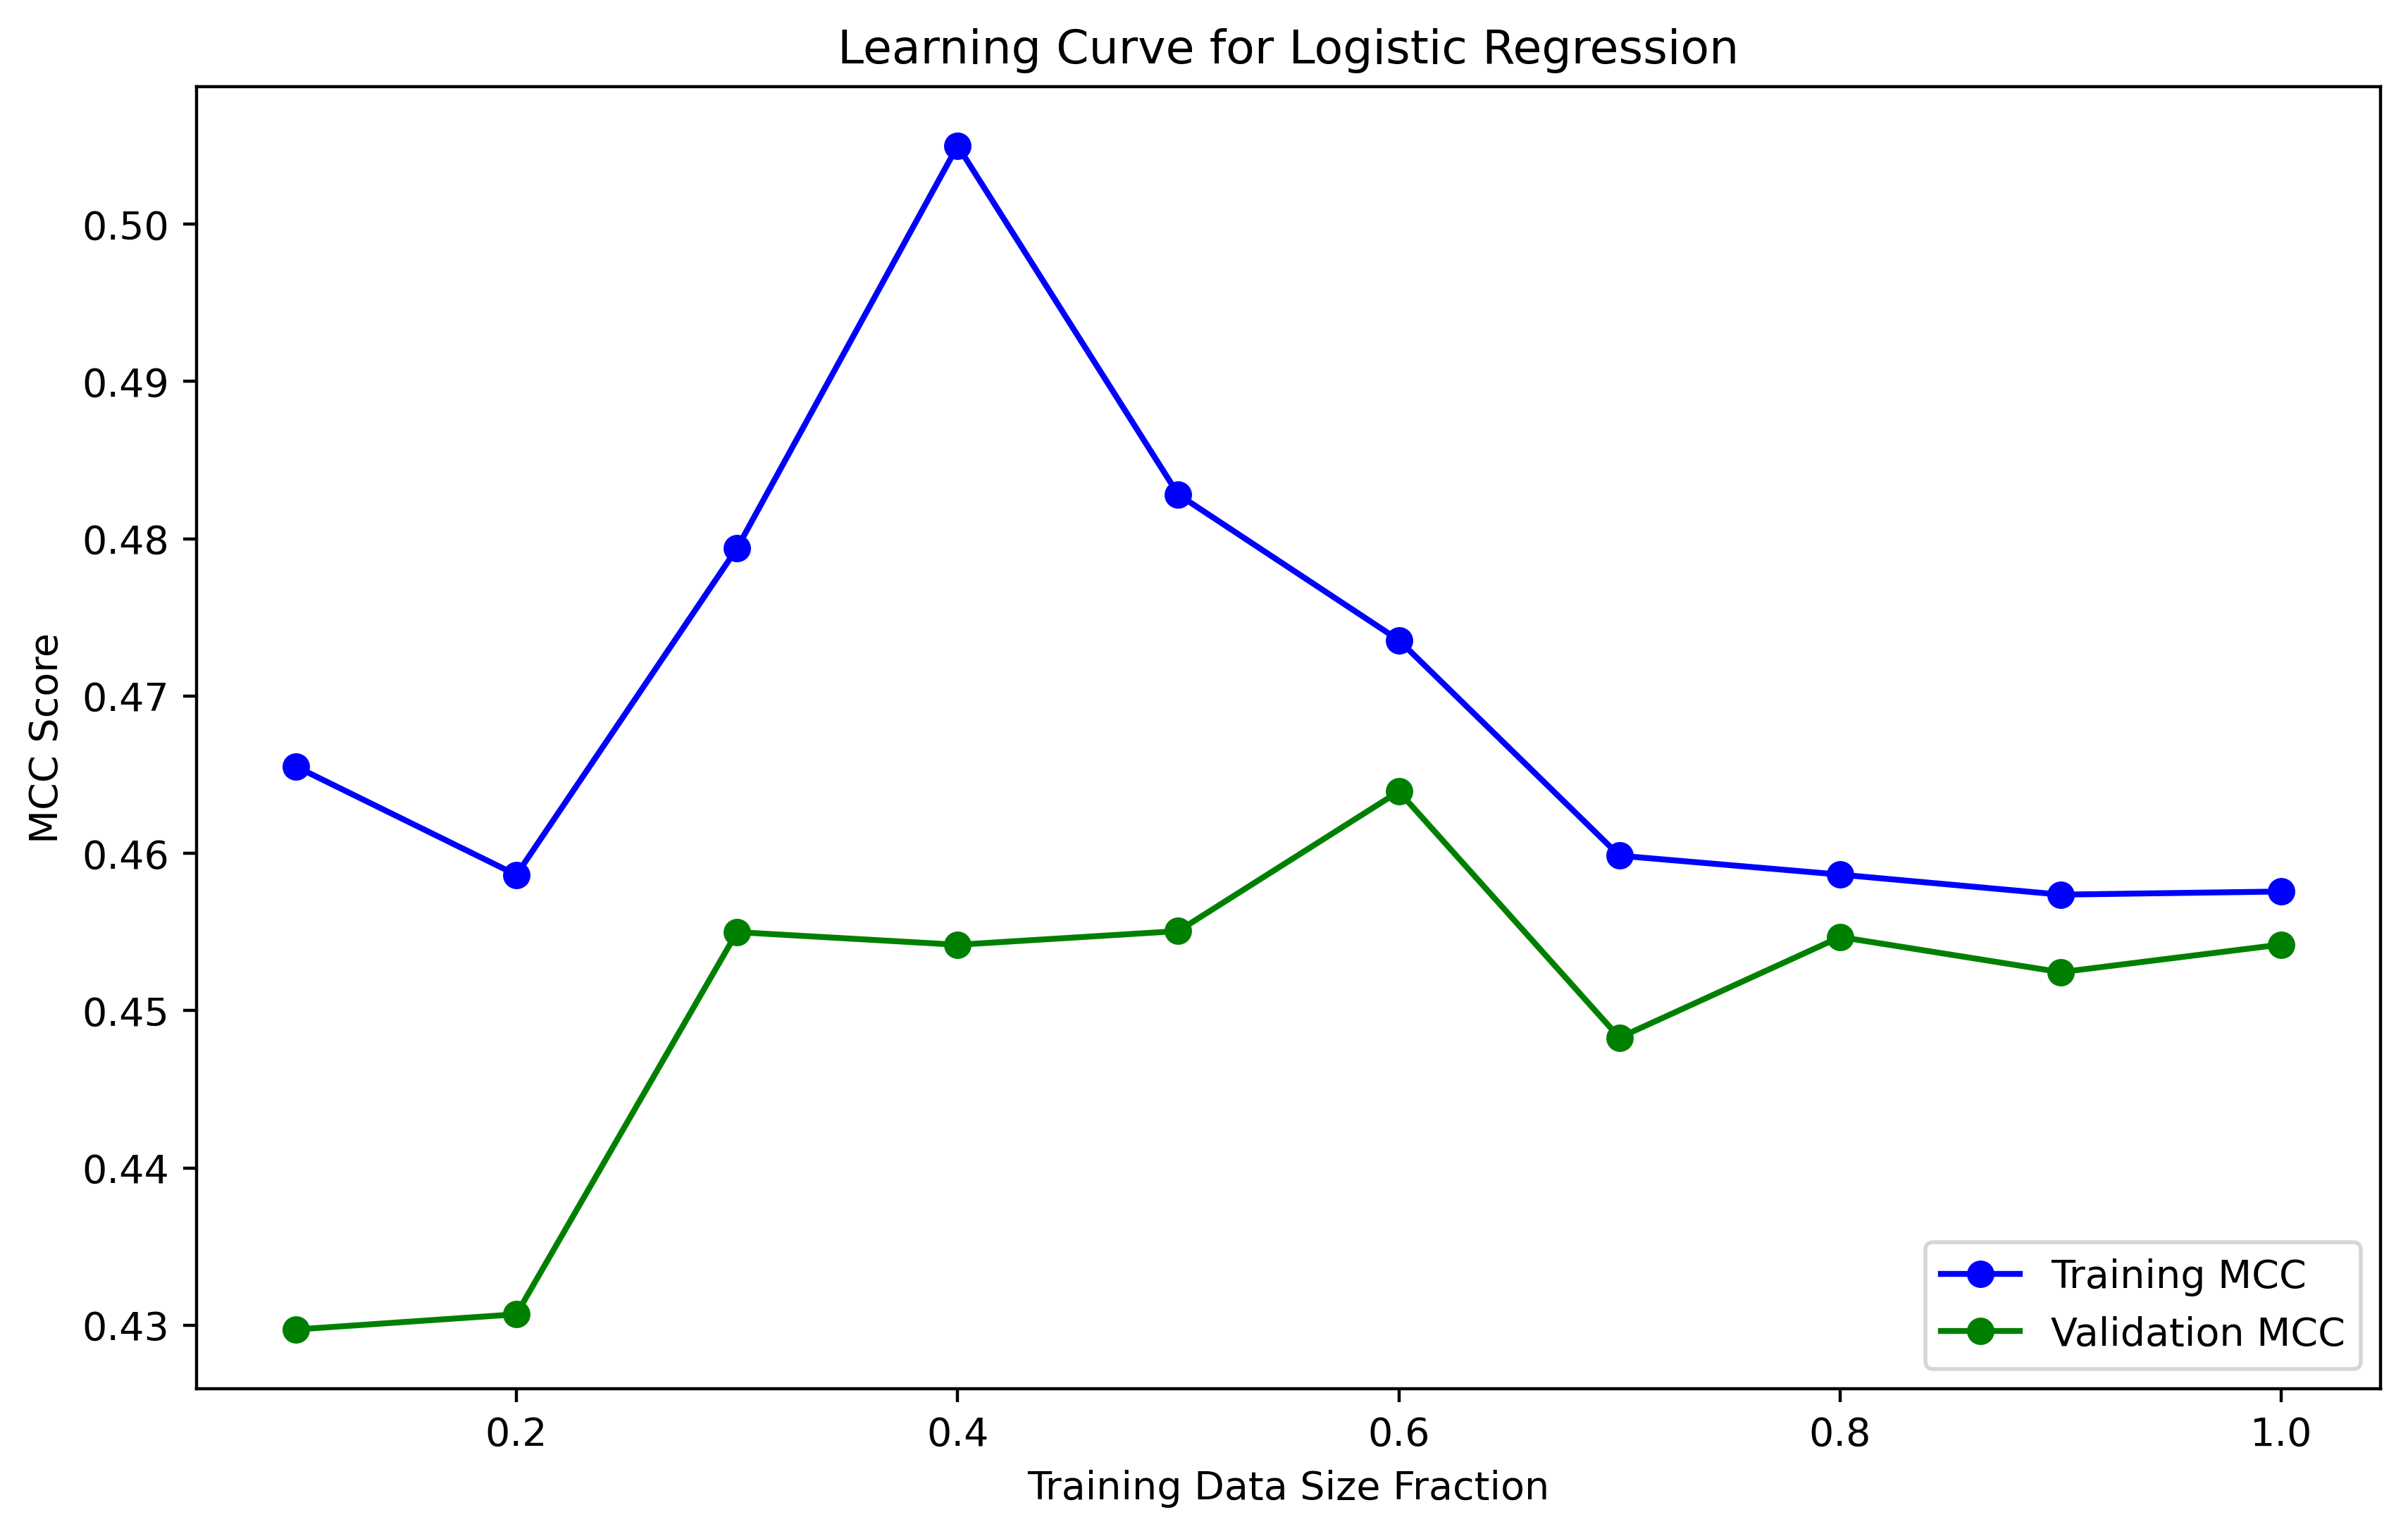

In [62]:
# Define training sizes and GroupKFold
train_sizes = np.linspace(0.1, 1.0, 10)
group_kfold = GroupKFold(n_splits=5)
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = sum(y_true == 1)
    N = sum(y_true == 0)

    Tp = sum((y_true == 1) & (y_pred == 1))
    Fp = sum((y_true == 0) & (y_pred == 1))

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt((Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return mcc
# Initialize lists to store average training and validation scores
train_mcc_scores = []
validation_mcc_scores = []

# Loop over each training size
for train_size in train_sizes:
    size_train_mcc_scores = []
    size_validation_mcc_scores = []


    # Loop over each fold
    for train_index, test_index in group_kfold.split(X, y, groups):
        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_train = groups[train_index]


        # Get unique groups and sample a subset of them
        unique_groups = np.unique(groups_train)
        # print("Total unique groups:", len(unique_groups))

        n_sampled_groups = int(train_size * len(unique_groups))
        sampled_groups = np.random.choice(unique_groups, n_sampled_groups, replace=False)
        # print("Sampled groups:", sampled_groups)
        # print("Number of sampled groups:", len(sampled_groups))
        # Select data corresponding to sampled groups
        train_subset_mask =  np.isin(groups_train, sampled_groups)
        # print("Mask values:", np.unique(train_subset_mask))
        X_train_subset = X_train[train_subset_mask]
        y_train_subset = y_train[train_subset_mask]


        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_subset)
        X_test_scaled = scaler.transform(X_test)


        # Train a RandomForestClassifier model
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train_scaled, y_train_subset)

        # Compute MCC
        train_mcc = matthews(y_train_subset, model.predict(X_train_scaled))
        validation_mcc = matthews(y_test, model.predict(X_test_scaled))

        size_train_mcc_scores.append(train_mcc)
        size_validation_mcc_scores.append(validation_mcc)

    # Average scores across all folds
    train_mcc_scores.append(np.mean(size_train_mcc_scores))
    validation_mcc_scores.append(np.mean(size_validation_mcc_scores))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mcc_scores, label='Training MCC', color='blue', marker='o')
plt.plot(train_sizes, validation_mcc_scores, label='Validation MCC', color='green', marker='o')
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Data Size Fraction')
plt.ylabel('MCC Score')
plt.legend(loc='lower right')

name = os.path.join(output_directory, '6_learn_logistic.png')
plt.savefig(name, bbox_inches='tight', dpi=400) 

### 4.7.1 Random Forest

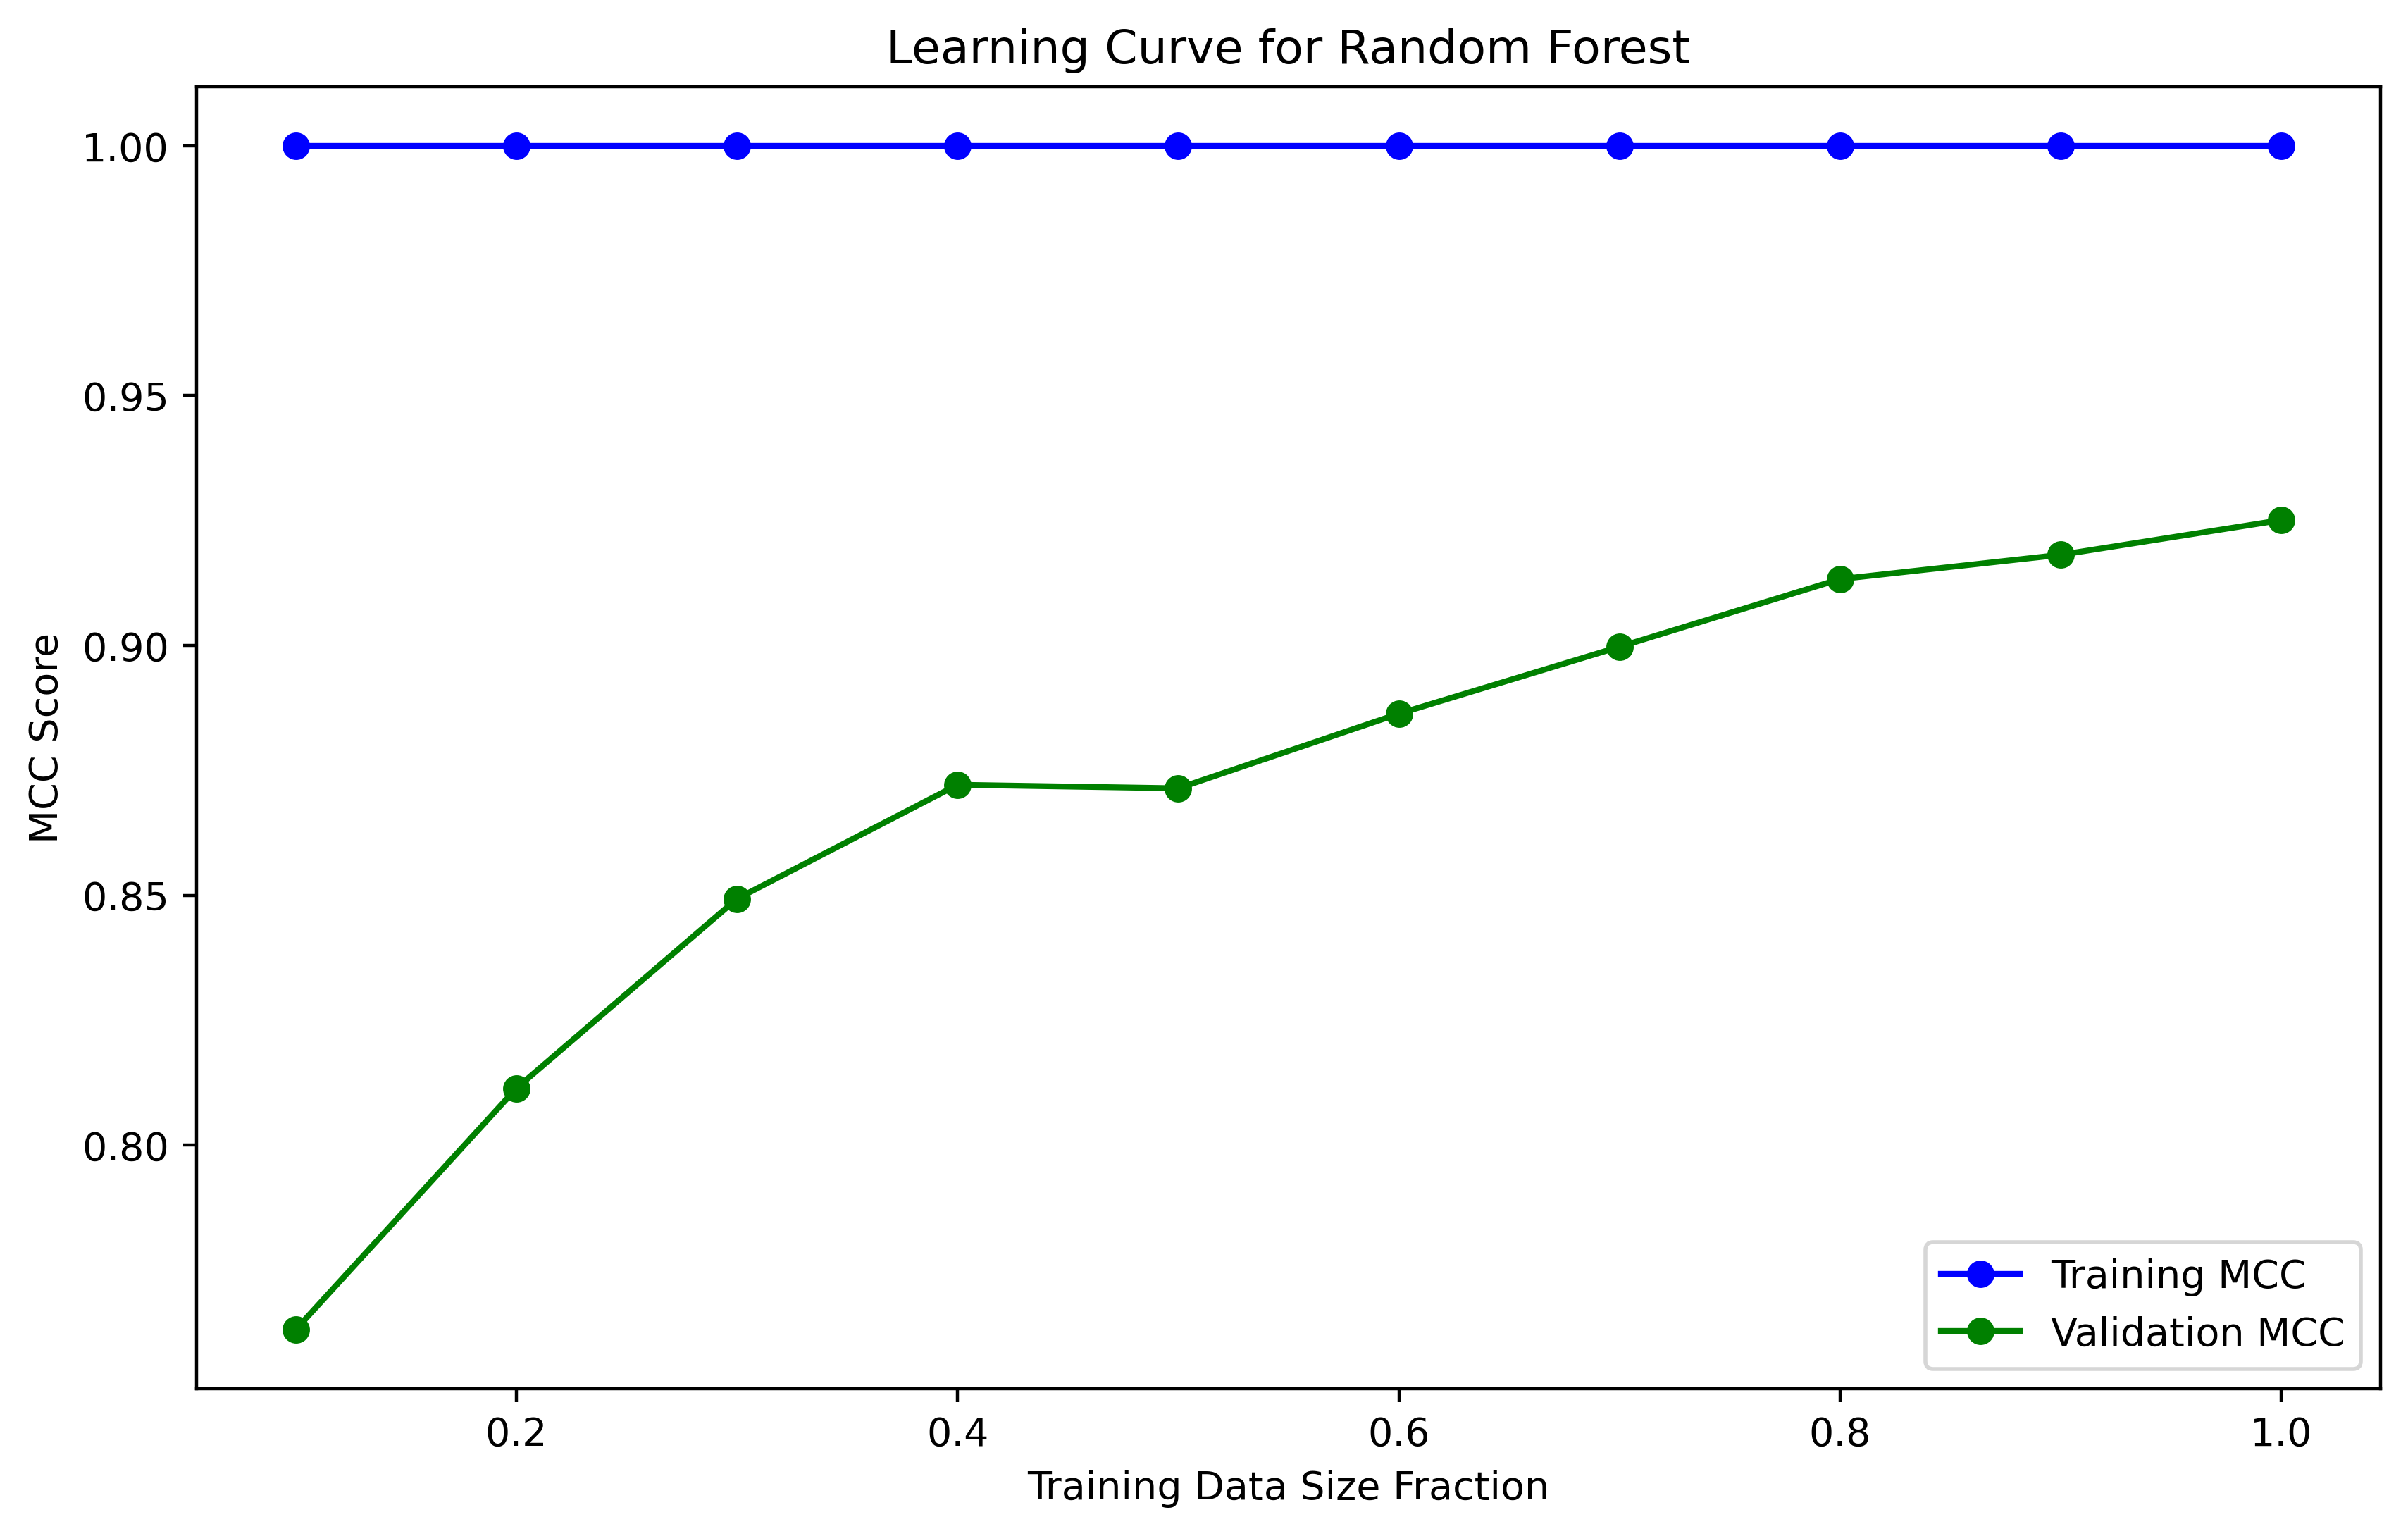

In [63]:
# Define training sizes and GroupKFold
train_sizes = np.linspace(0.1, 1.0, 10)
group_kfold = GroupKFold(n_splits=5)
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = sum(y_true == 1)
    N = sum(y_true == 0)

    Tp = sum((y_true == 1) & (y_pred == 1))
    Fp = sum((y_true == 0) & (y_pred == 1))

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt((Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return mcc
# Initialize lists to store average training and validation scores
train_mcc_scores = []
validation_mcc_scores = []

# Loop over each training size
for train_size in train_sizes:
    size_train_mcc_scores = []
    size_validation_mcc_scores = []


    # Loop over each fold
    for train_index, test_index in group_kfold.split(X, y, groups):
        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_train = groups[train_index]


        # Get unique groups and sample a subset of them
        unique_groups = np.unique(groups_train)
        # print("Total unique groups:", len(unique_groups))

        n_sampled_groups = int(train_size * len(unique_groups))
        sampled_groups = np.random.choice(unique_groups, n_sampled_groups, replace=False)
        # print("Sampled groups:", sampled_groups)
        # print("Number of sampled groups:", len(sampled_groups))
        # Select data corresponding to sampled groups
        train_subset_mask =  np.isin(groups_train, sampled_groups)
        # print("Mask values:", np.unique(train_subset_mask))
        X_train_subset = X_train[train_subset_mask]
        y_train_subset = y_train[train_subset_mask]


        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_subset)
        X_test_scaled = scaler.transform(X_test)


        params =  {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        # Train a RandomForestClassifier model
        model = RandomForestClassifier(**params)
        model.fit(X_train_scaled, y_train_subset)

        # Compute MCC
        train_mcc = matthews_corrcoef(y_train_subset, model.predict(X_train_scaled))
        validation_mcc = matthews_corrcoef(y_test, model.predict(X_test_scaled))

        size_train_mcc_scores.append(train_mcc)
        size_validation_mcc_scores.append(validation_mcc)

    # Average scores across all folds
    train_mcc_scores.append(np.mean(size_train_mcc_scores))
    validation_mcc_scores.append(np.mean(size_validation_mcc_scores))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mcc_scores, label='Training MCC', color='blue', marker='o')
plt.plot(train_sizes, validation_mcc_scores, label='Validation MCC', color='green', marker='o')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Data Size Fraction')
plt.ylabel('MCC Score')
plt.legend(loc='lower right')

name = os.path.join(output_directory, '6_learn_random_forest.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  

### 4.7.1 LightGBM

[LightGBM] [Info] Number of positive: 227, number of negative: 663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 890, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255056 -> initscore=-1.071825
[LightGBM] [Info] Start training from score -1.071825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 243, number of negative: 647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 890, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273034 -> initscore=-0.979285
[Li

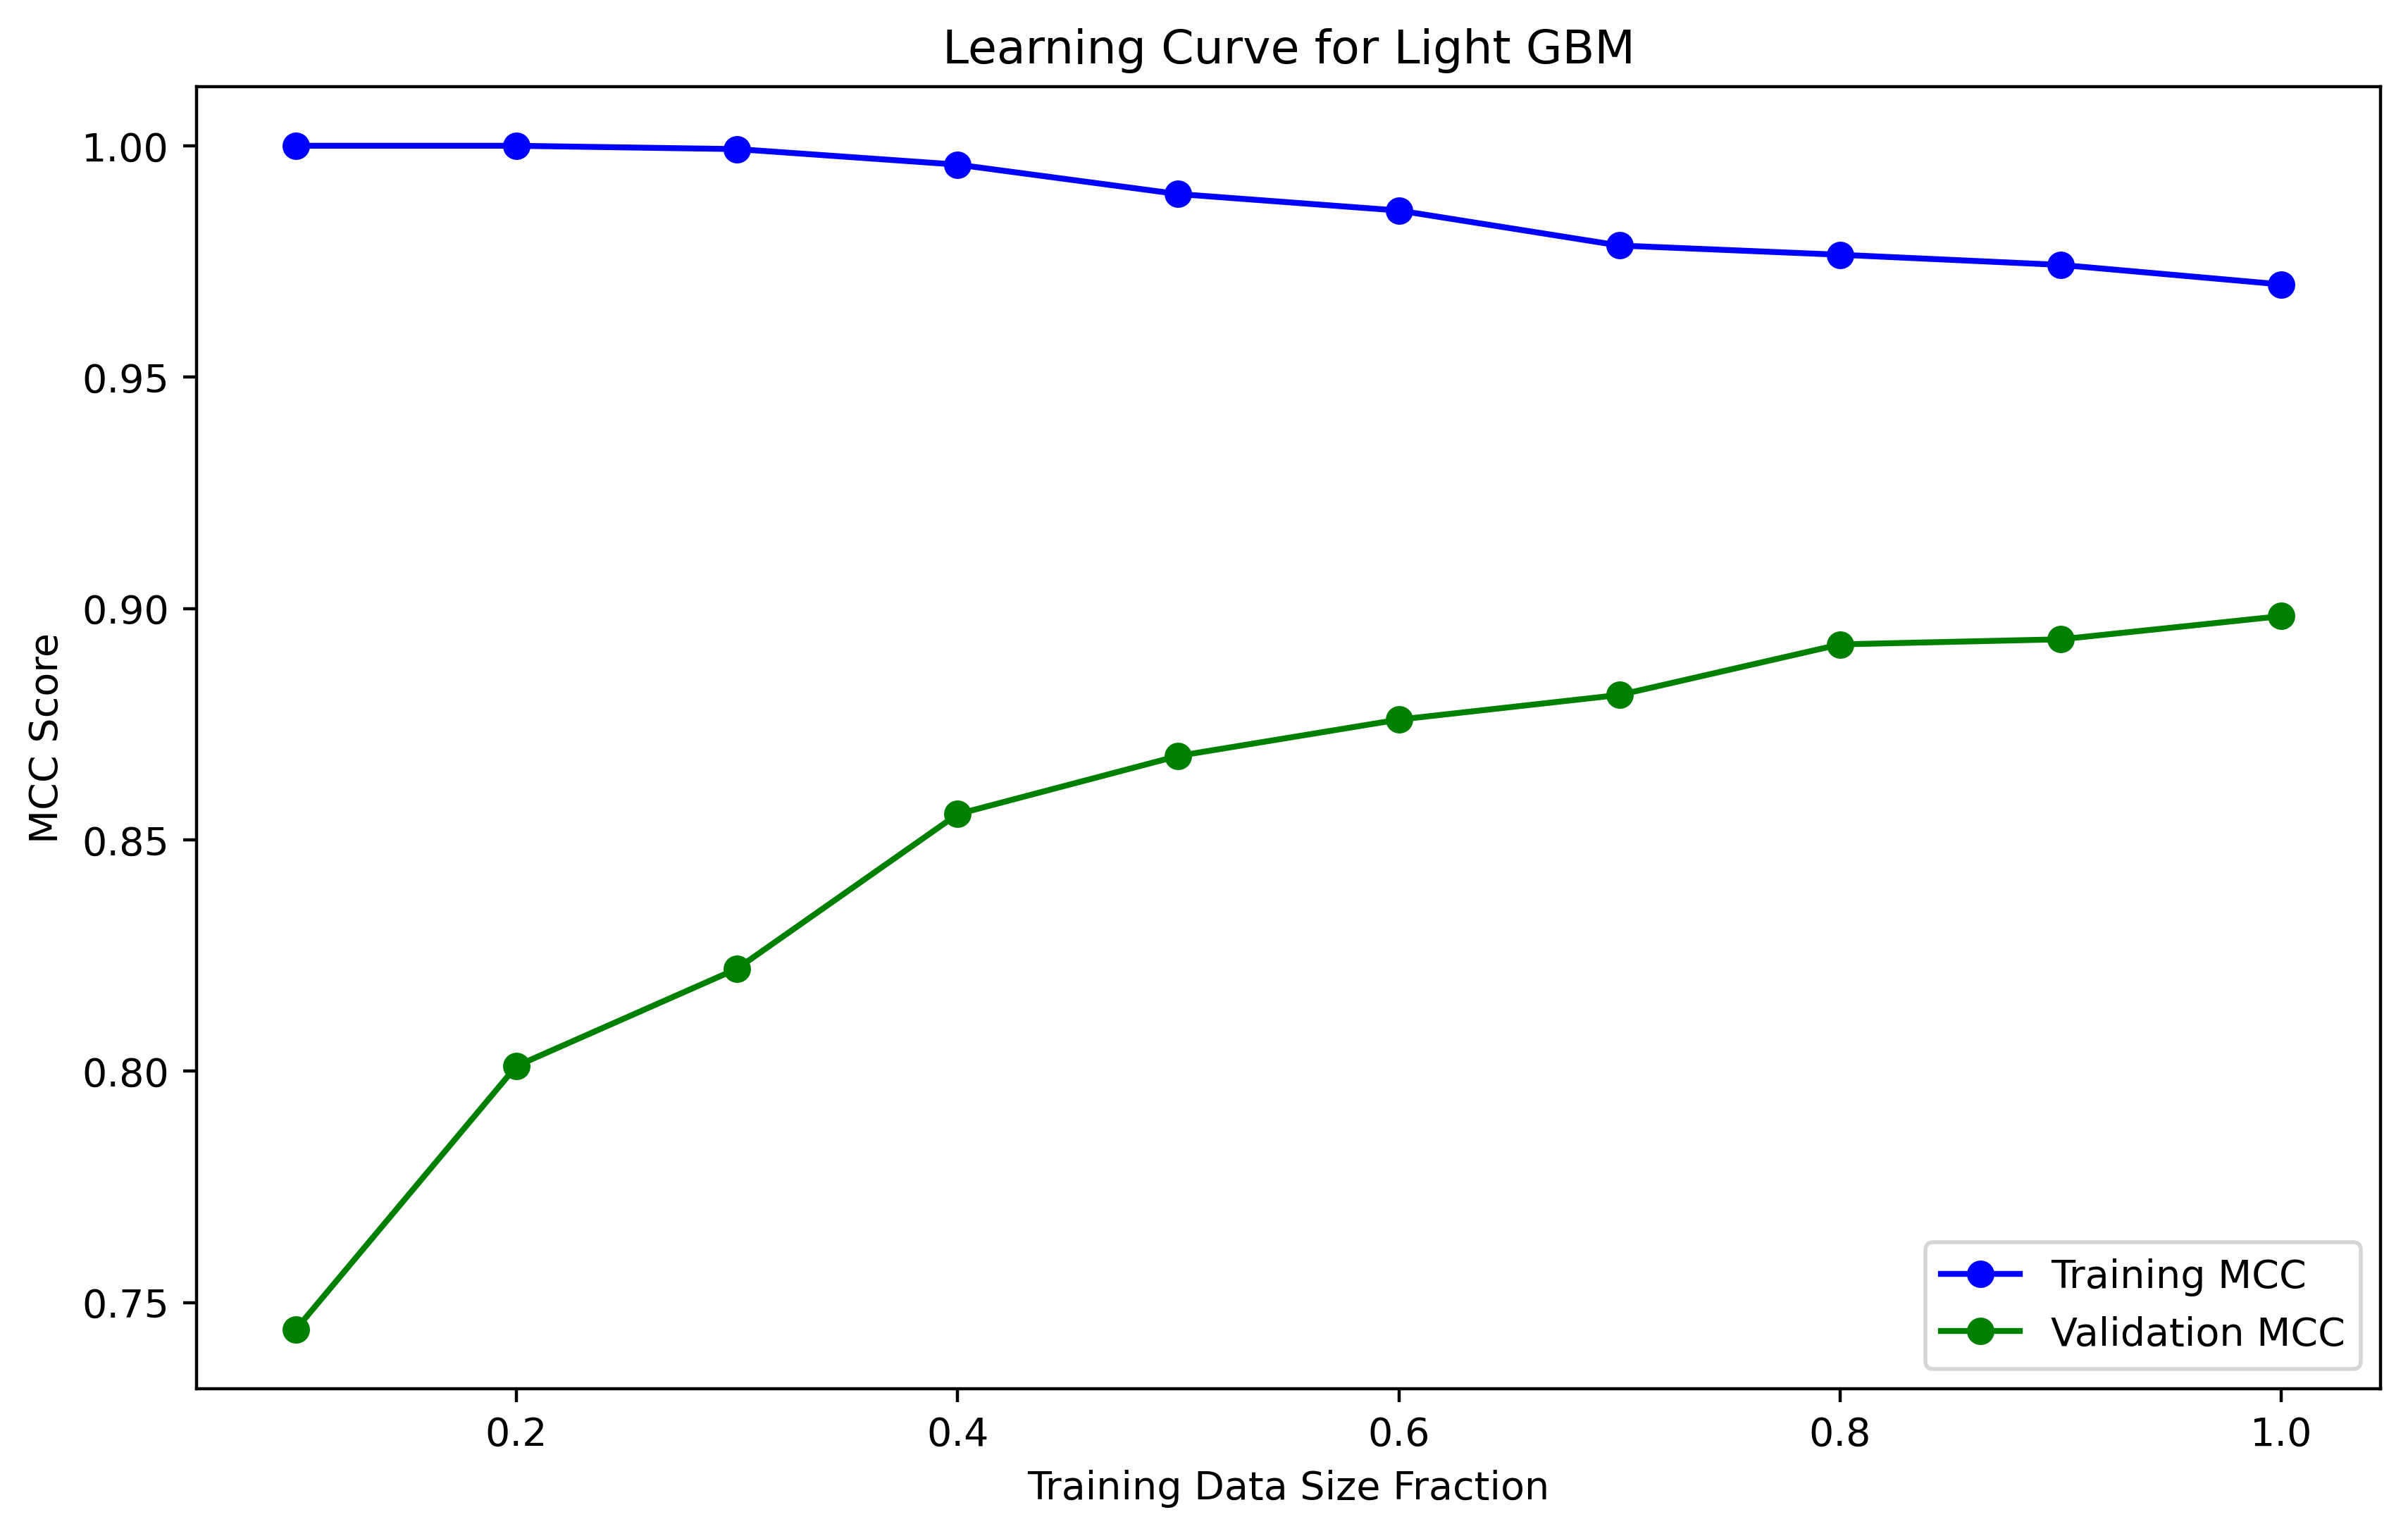

In [66]:
# Define training sizes and GroupKFold
train_sizes = np.linspace(0.1, 1.0, 10)
group_kfold = GroupKFold(n_splits=5)
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = sum(y_true == 1)
    N = sum(y_true == 0)

    Tp = sum((y_true == 1) & (y_pred == 1))
    Fp = sum((y_true == 0) & (y_pred == 1))

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt((Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return mcc
# Initialize lists to store average training and validation scores
train_mcc_scores = []
validation_mcc_scores = []

# Loop over each training size
for train_size in train_sizes:
    size_train_mcc_scores = []
    size_validation_mcc_scores = []


    # Loop over each fold
    for train_index, test_index in group_kfold.split(X, y, groups):
        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_train = groups[train_index]


        # Get unique groups and sample a subset of them
        unique_groups = np.unique(groups_train)
        # print("Total unique groups:", len(unique_groups))

        n_sampled_groups = int(train_size * len(unique_groups))
        sampled_groups = np.random.choice(unique_groups, n_sampled_groups, replace=False)
        # print("Sampled groups:", sampled_groups)
        # print("Number of sampled groups:", len(sampled_groups))
        # Select data corresponding to sampled groups
        train_subset_mask =  np.isin(groups_train, sampled_groups)
        # print("Mask values:", np.unique(train_subset_mask))
        X_train_subset = X_train[train_subset_mask]
        y_train_subset = y_train[train_subset_mask]


        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_subset)
        X_test_scaled = scaler.transform(X_test)


        params =  {'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        # Train a RandomForestClassifier model
        model = lgb.LGBMClassifier()
        model.fit(X_train_scaled, y_train_subset)

        # Compute MCC
        train_mcc = matthews_corrcoef(y_train_subset, model.predict(X_train_scaled))
        validation_mcc = matthews_corrcoef(y_test, model.predict(X_test_scaled))

        size_train_mcc_scores.append(train_mcc)
        size_validation_mcc_scores.append(validation_mcc)

    # Average scores across all folds
    train_mcc_scores.append(np.mean(size_train_mcc_scores))
    validation_mcc_scores.append(np.mean(size_validation_mcc_scores))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mcc_scores, label='Training MCC', color='blue', marker='o')
plt.plot(train_sizes, validation_mcc_scores, label='Validation MCC', color='green', marker='o')
plt.title('Learning Curve for Light GBM')
plt.xlabel('Training Data Size Fraction')
plt.ylabel('MCC Score')
plt.legend(loc='lower right')

name = os.path.join(output_directory, '6_learn_random_forest.png')
# plt.savefig(name, bbox_inches='tight', dpi=400)  

# 5. Predictions on discarded

In [71]:
discarded = pd.read_csv("../data/test/discarded.csv")

features = ['genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'tRNAs_inphared', 'cds_coding_density','jumbophage_inphared', 'topology_linear', 
       'topology_circular', 'transl_table',  'CARD_AMR_Genes',
       'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative', 
       'molecule_inphared_type_DNA',  'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA' ]


discarded = discarded.set_index(discarded.columns[0])
discarded = discarded[features]
discarded.head()

genome_length_inphared  gc_%_inphared  cds_number_inphared  \
id                                                                     
GU339467                 53332.0         64.530                 90.0   
MF417929                 32618.0         39.218                 42.0   
MH616963                 94878.0         28.507                 89.0   
MH552500                 90023.0         29.180                 86.0   
BK010471                 97065.0         29.274                 91.0   

          positive_strand_%_inphared  negative_strand_%_inphared  \
id                                                                 
GU339467                   40.000000                   60.000000   
MF417929                   16.666667                   83.333333   
MH616963                   56.179775                   43.820225   
MH552500                   47.674419                   52.325581   
BK010471                   50.549451                   49.450549   

          coding_capacity_inphared  tRNAs_inphared  cds_coding_density  \
id                                                                       
GU339467                 90.416635             1.0               90.11   
MF417929                 89.416886             0.0               89.29   
MH616963                 94.964059             2.0               94.70   
MH552500                 92.927363             2.0               92.83   
BK010471                 94.458353             0.0               94.52   

          jumbophage_inphared  topology_linear  ...  tail  tmRNAs  \
id                                              ...                 
GU339467                  0.0             True  ...  13.0     0.0   
MF417929                  0.0             True  ...  10.0     0.0   
MH616963                  0.0             True  ...   1.0     0.0   
MH552500                  0.0             True  ...   0.0     0.0   
BK010471                  0.0             True  ...   2.0     0.0   

          transcription  unkown_function  frame_positive  frame_negative  \
id                                                                         
GU339467            3.0             44.0            36.0            54.0   
MF417929            1.0             17.0             7.0            35.0   
MH616963            0.0             74.0            50.0            39.0   
MH552500            0.0             72.0            41.0            46.0   
BK010471            0.0             74.0            47.0            45.0   

          molecule_inphared_type_DNA  molecule_inphared_type_ss-DNA  \
id                                                                    
GU339467                        True                          False   
MF417929                        True                          False   
MH616963                        True                          False   
MH552500                        True                          False   
BK010471                        True                          False   

          molecule_inphared_type_RNA  molecule_inphared_type_ss-RNA  
id                                                                   
GU339467                       False                          False  
MF417929                       False                          False  
MH616963                       False                          False  
MH552500                       False                          False  
BK010471                       False                          False  

[5 rows x 32 columns]

In [73]:

args_model = "../models/logistic.pkl"
# args_model = "../data/test/model/model.pkl"
args_output = '../data/test/reports/'
# Making the prediction -----

# Load the model using the provided path
model = pickle.load(open(args_model, "rb"))

# Predictions
new_data_pred = model.predict(discarded)

# Get the probabilities for the predicted class for each instance
probas = model.predict_proba(discarded)
predicted_indices = np.argmax(probas, axis=1)  # Get index of max proba for each sample
new_data_pred_proba = [probas[i][predicted_indices[i]] for i in range(len(predicted_indices))]

# Prepare the output DataFrame
output_df = pd.DataFrame({
    'id': discarded.index,
    'prediction': new_data_pred,
    'prediction_probability': new_data_pred_proba
})

output_df = output_df.sort_values(by='prediction_probability', ascending=False)

csv_output_path = args_output + "predictions2.csv"

# Uncomment the following line if you want to save the output to a CSV
# output_df.to_csv(csv_output_path, index=False)

# python -m src.models.predict_model -d data/interim/genbank_engineering/50_sequences.gb

print()
print(f"The output has been saved in {csv_output_path}. The first 5 entries are: ")
print(output_df.head())





The output has been saved in ../data/test/reports/predictions2.csv. The first 5 entries are: 
              id  prediction  prediction_probability
0       GU339467           1                     1.0
10036  NC_054424           1                     1.0
10024  NC_054443           1                     1.0
10025  NC_054442           1                     1.0
10026  NC_054441           1                     1.0


/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


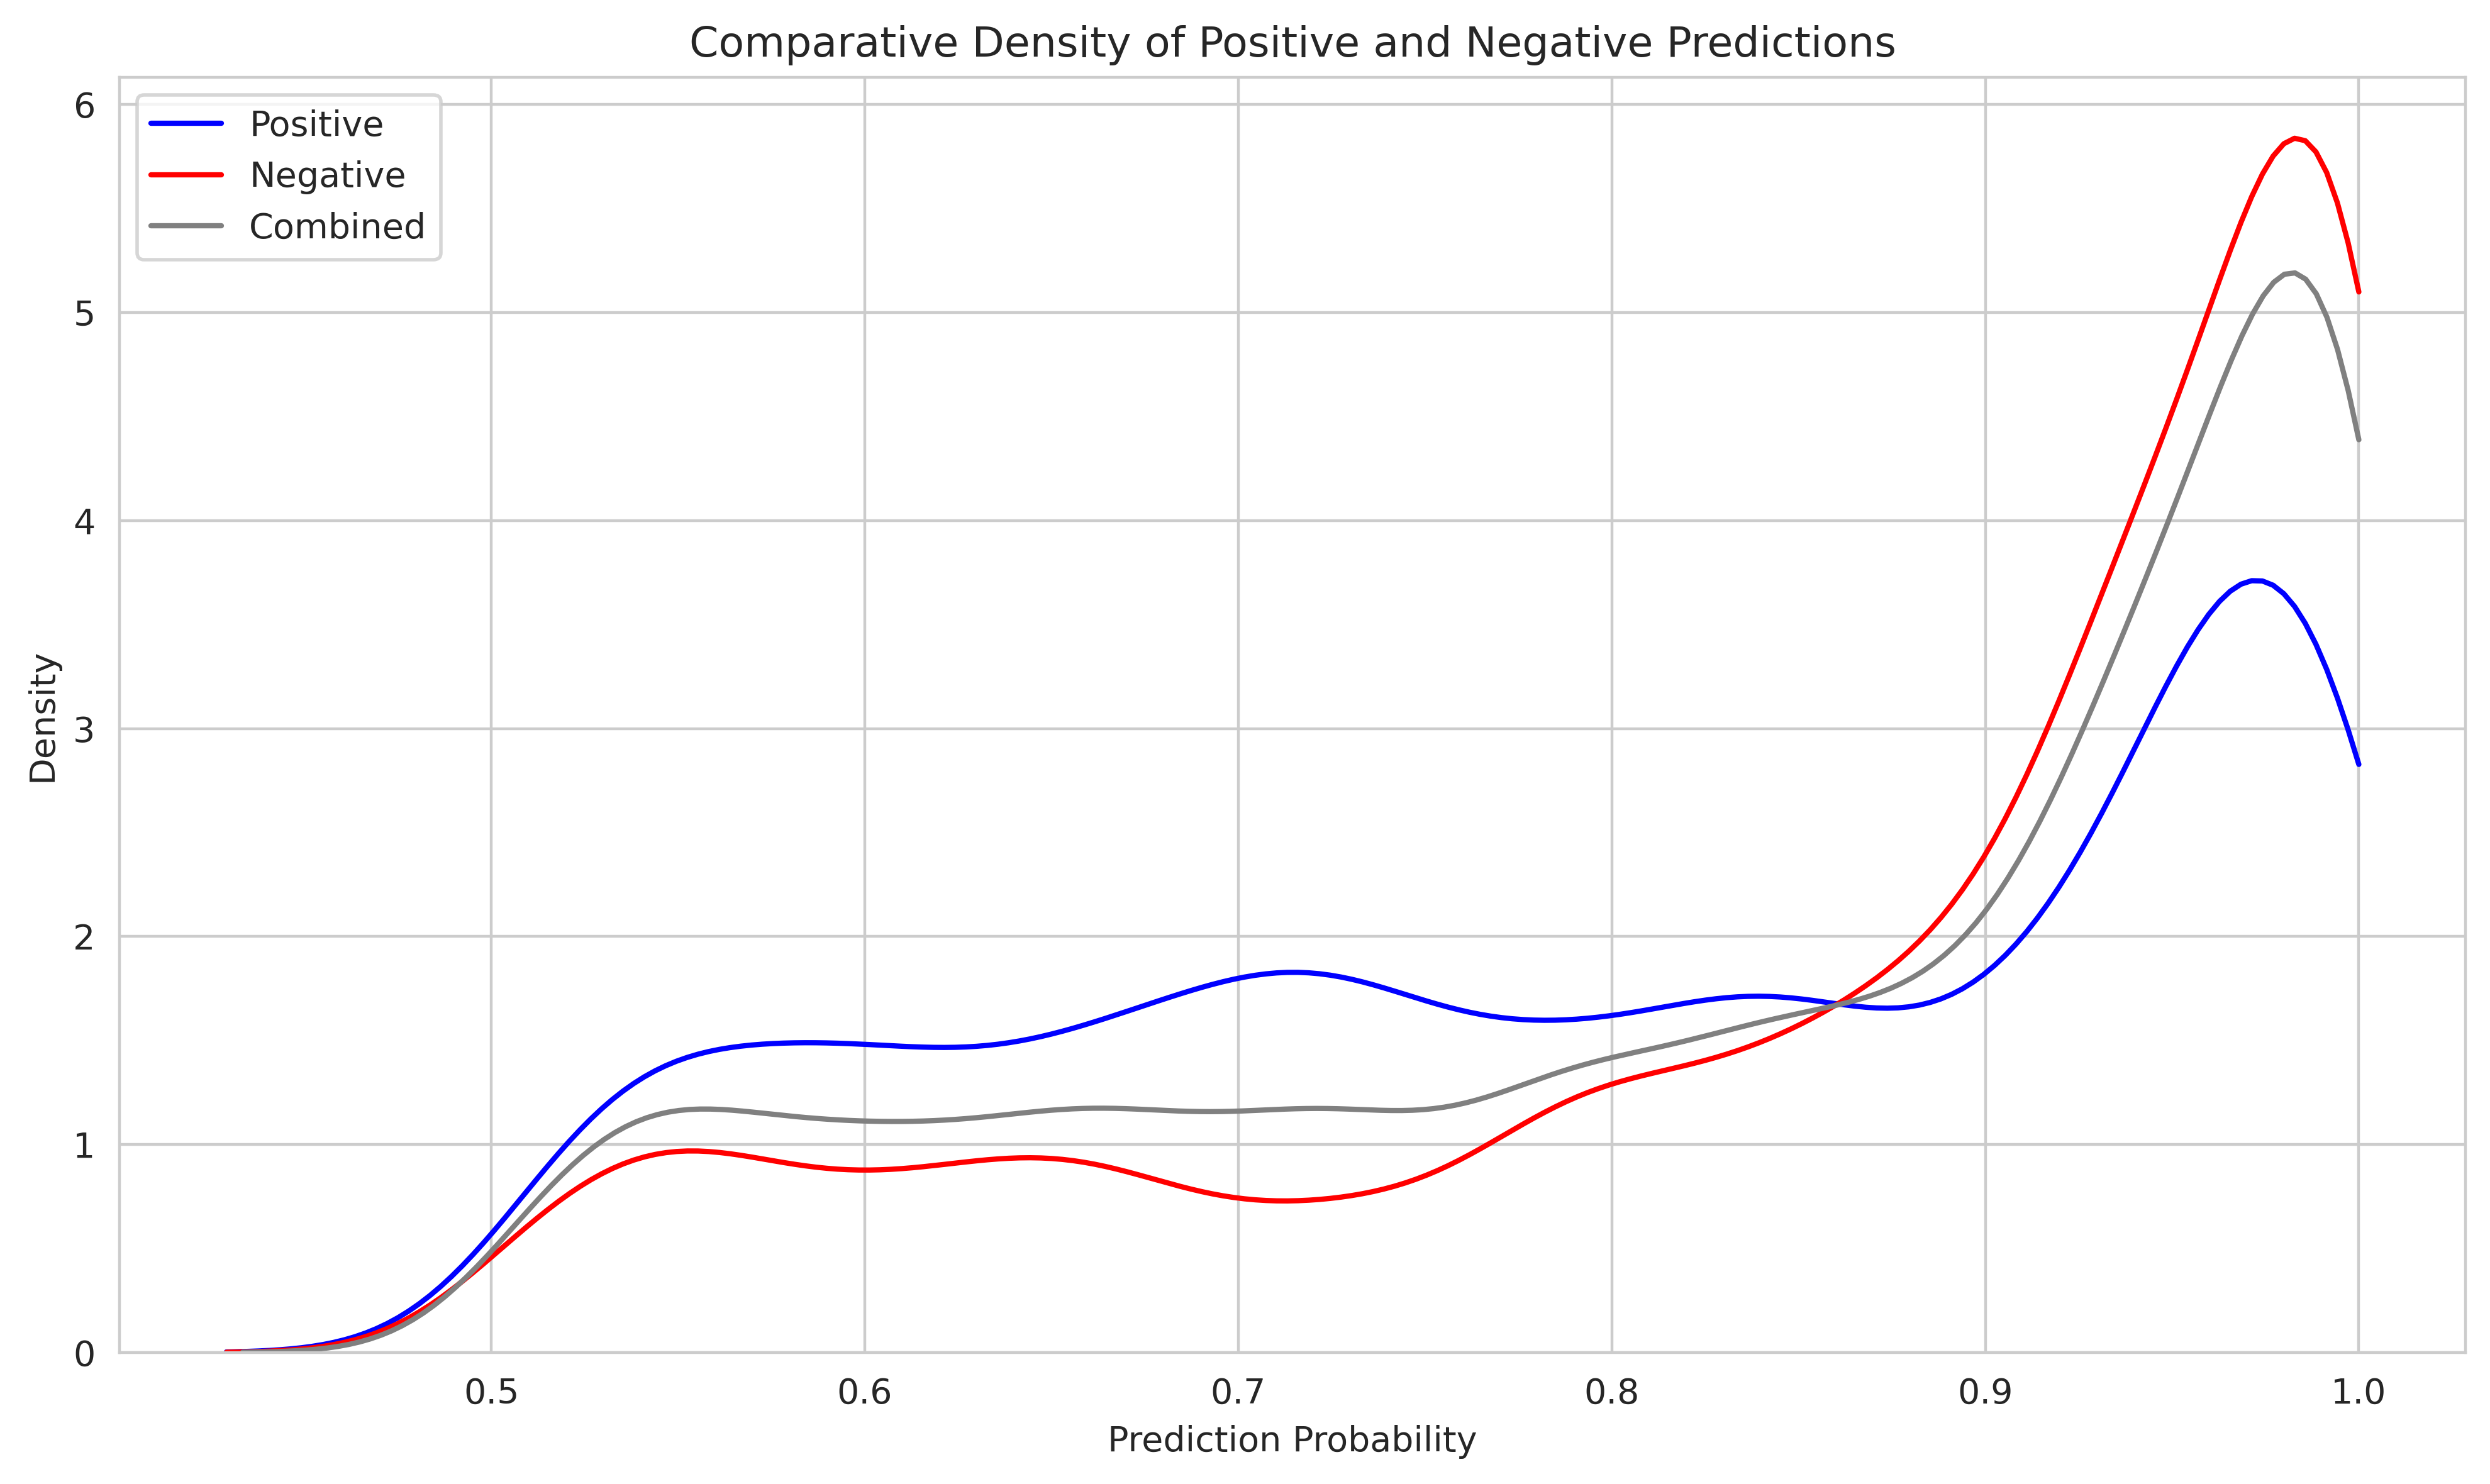

In [75]:
df = pd.read_csv("../data/test/reports/predictions.csv")
output_directory = "../reports/figures/"
name = os.path.join(output_directory, 'KDE.png')
# KDE Plot
sns.set_style("whitegrid")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[df['prediction'] == 'positive']['prediction_probability'], fill=False, label='Positive', color="blue", clip=(0, 1))
    sns.kdeplot(df[df['prediction'] == 'negative']['prediction_probability'], fill=False, label='Negative', color="red", clip=(0, 1))
    sns.kdeplot(df['prediction_probability'], fill=False, label='Combined', color='grey', clip=(0, 1))
    plt.xlabel('Prediction Probability')
    plt.ylabel('Density')
    plt.title('Comparative Density of Positive and Negative Predictions')
    plt.legend()

    # Save KDE plot
    plt.tight_layout()


    name = os.path.join(output_directory, '7_KDE_discarded.png')
    # plt.savefig(name, bbox_inches='tight', dpi=400)     


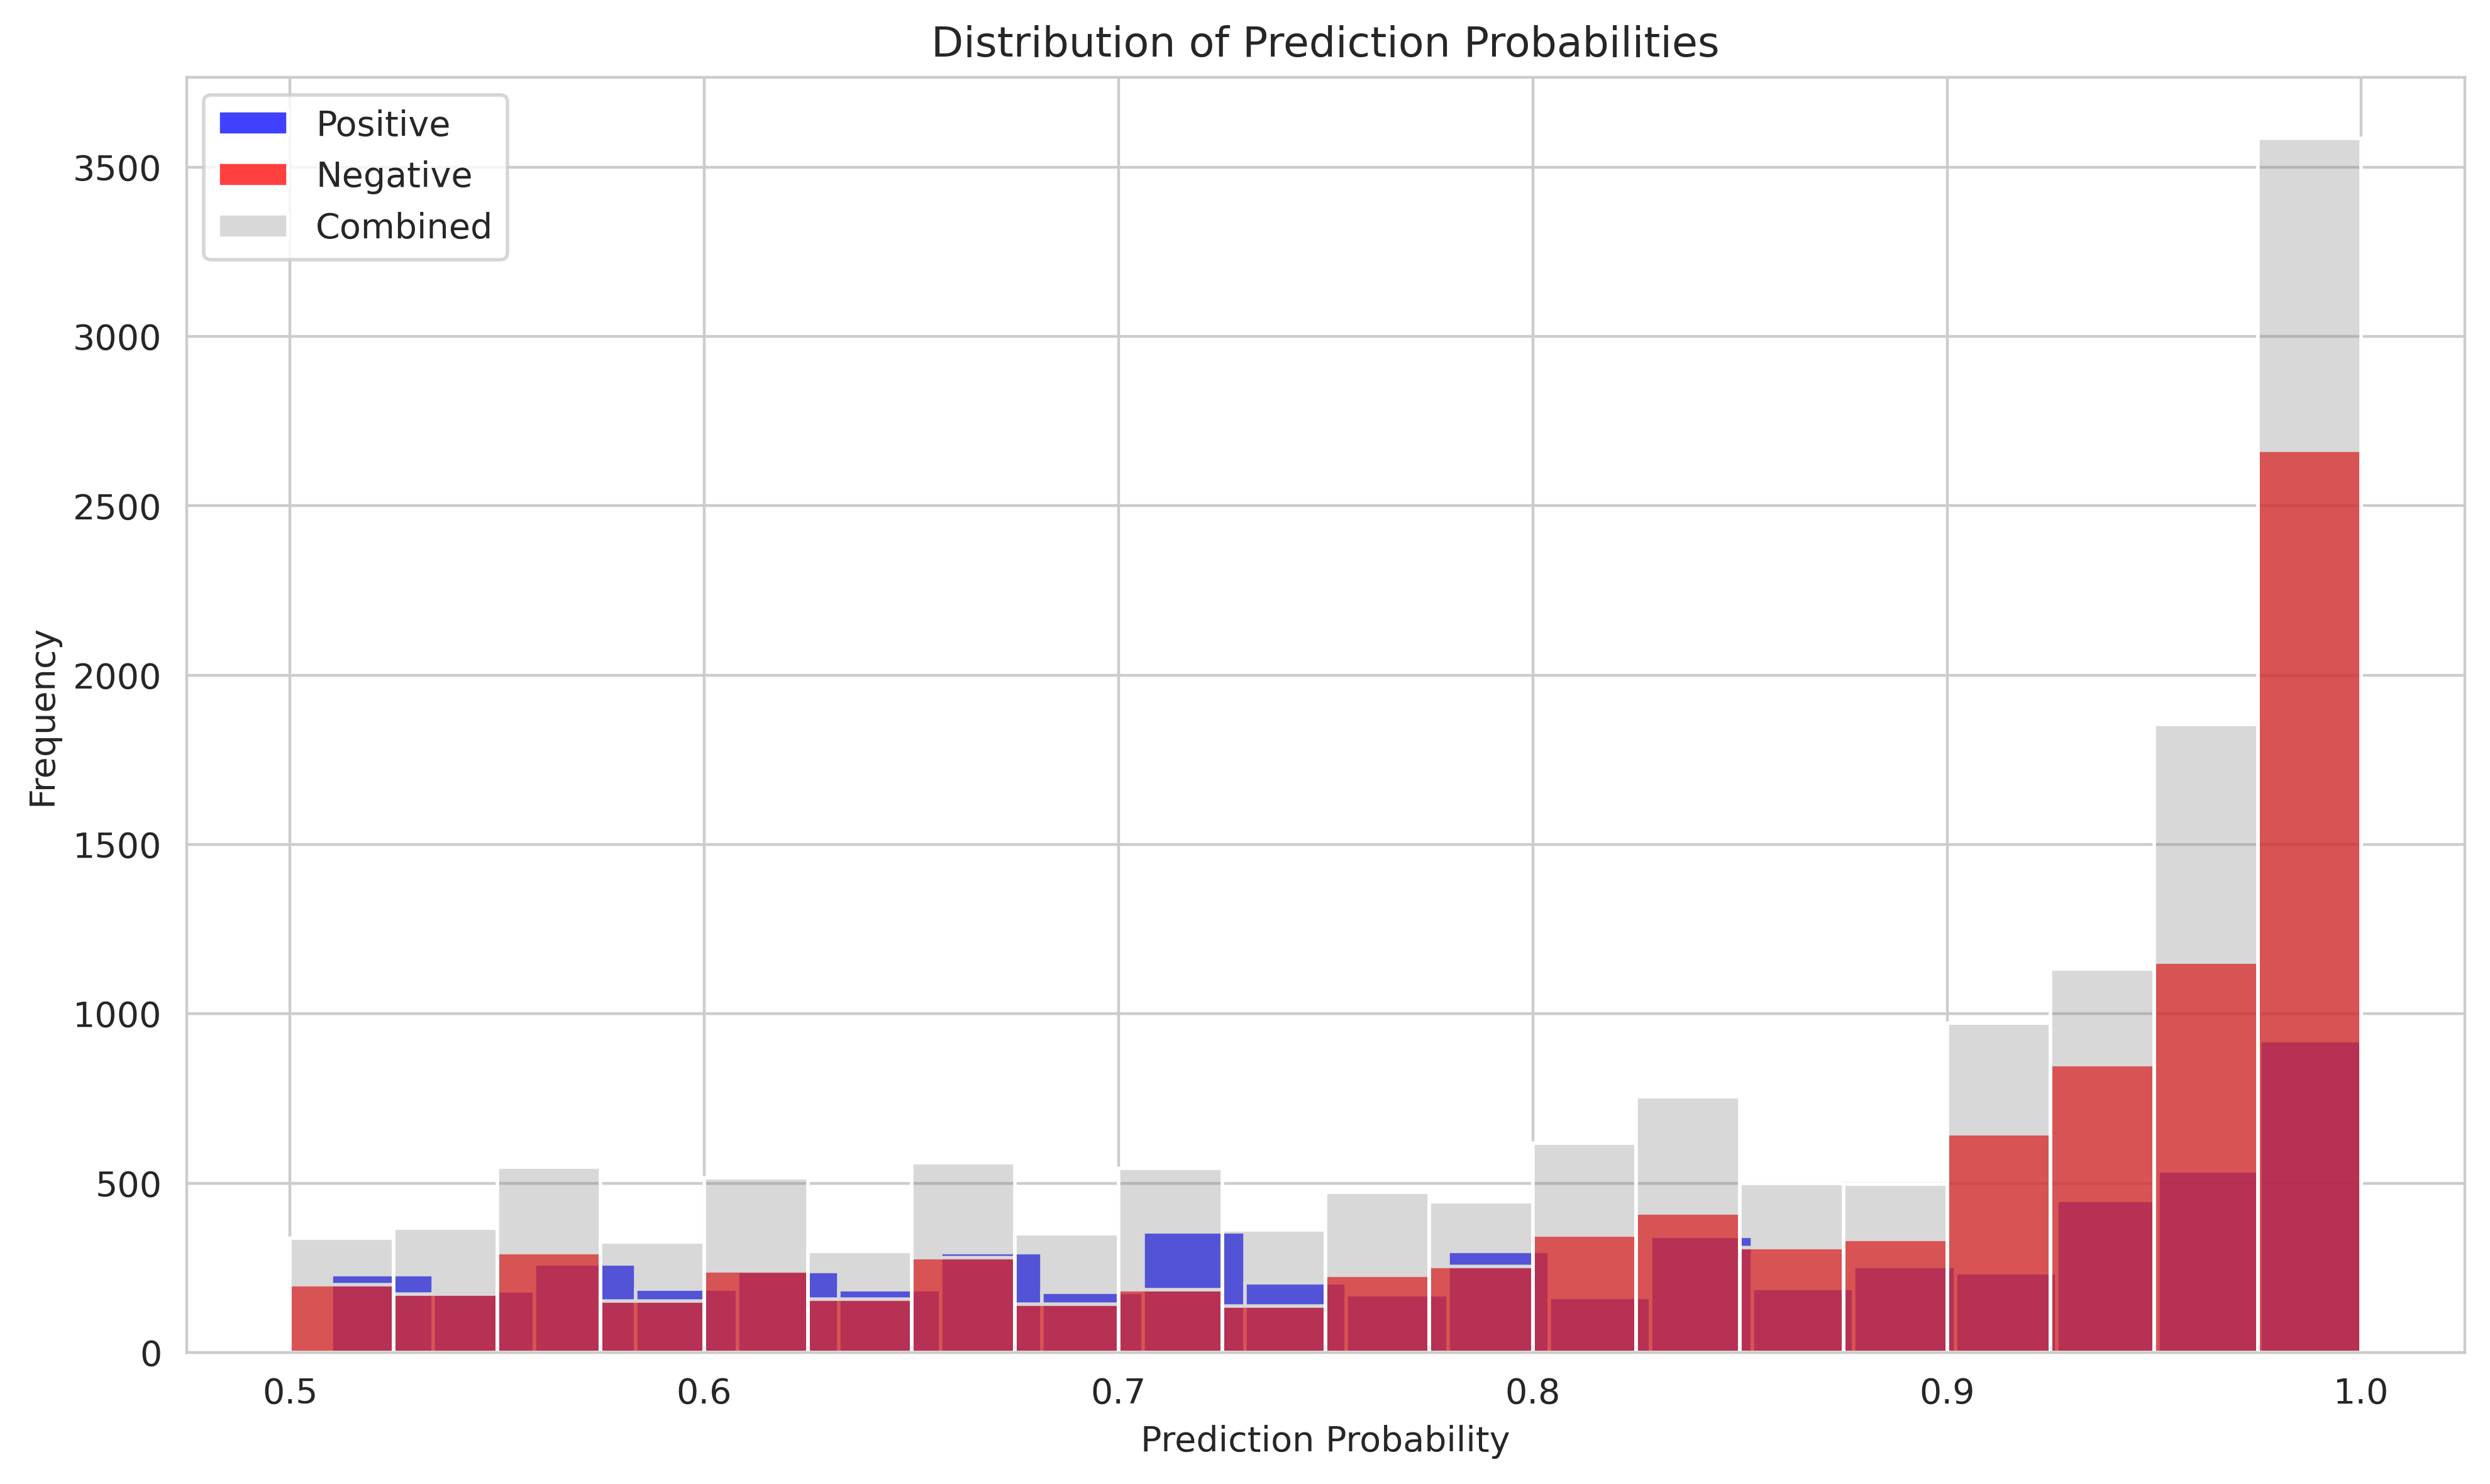

In [76]:
name = os.path.join(output_directory, 'histogram.png')
# Histogram Plot
sns.set_style("whitegrid")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['prediction'] == 'positive']['prediction_probability'], kde=False, label='Positive', color="blue", bins=20)
    sns.histplot(df[df['prediction'] == 'negative']['prediction_probability'], kde=False, label='Negative', color="red", bins=20)
    sns.histplot(df['prediction_probability'], kde=False, label='Combined', color='grey', bins=20, alpha=0.3)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()

    # Save histogram plot
    plt.tight_layout()
    name = os.path.join(output_directory, '7_histogram_discarded.png')
    # plt.savefig(name, bbox_inches='tight', dpi=400)     

### 6.2 Extra analyses on the discarded datasets

See 07_model 

In [ ]:
discarded = pd.read_csv("../data/test/discarded.csv")

features = ['id','genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'tRNAs_inphared', 'cds_coding_density','jumbophage_inphared', 'topology_linear', 
       'topology_circular', 'transl_table',  'CARD_AMR_Genes',
       'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative', 
       'molecule_inphared_type_DNA',  'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA' ]

discarded = discarded[features]
print(discarded.shape)
discarded.head()